In [2]:
import subprocess
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob

In [27]:
# Define data directory - adjust this to your local path
DATA_DIR = "../data/" 

# Function to run shell commands
def run_command(command):
    """Run shell command and return output"""
    print(f"Running: {command}")
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"Error: {result.stderr}")
    return result

# Function to get BCF files from local directory
def get_local_bcf_files():
    """Get list of BCF files matching the specific pattern"""
    file_pattern = os.path.join(DATA_DIR, "hgdp1kgp_chr*.filtered.SNV_INDEL.phased.shapeit5.bcf")
    file_paths = glob.glob(file_pattern)
    
    files = []
    for file_path in file_paths:
        file_name = os.path.basename(file_path)
        files.append({
            'name': file_name,
            'path': file_path
        })
    
    print(f"Found {len(files)} matching BCF files in {DATA_DIR}")
    for file in files[:5]:
        print(f" - {file['name']}")
    if len(files) > 5:
        print(f" - ...and {len(files) - 5} more files")
    
    return files

# Extract chromosome info from filename
def extract_chromosome(filename):
    """Extract chromosome number from filename"""
    match = re.search(r'chr(\d+|X|Y)', filename)
    if match:
        return match.group(1)
    return None

# Create variant type distribution plot
def plot_variant_distribution(bcf_file_path, chromosome):
    """Create SNP vs INDEL distribution pie chart"""
    print(f"Analyzing variant distribution for chromosome {chromosome}...")
    
    # Get variant counts
    command = f"bcftools stats {bcf_file_path}"
    result = run_command(command)
    
    # Extract SNP and indel counts
    snps = 0
    indels = 0
    
    for line in result.stdout.split('\n'):
        if line.startswith('SN\t0\tnumber of SNPs:'):
            snps = int(line.split('\t')[3])
        elif line.startswith('SN\t0\tnumber of indels:'):
            indels = int(line.split('\t')[3])
    
    # Create pie chart
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.pie([snps, indels], labels=['SNPs', 'INDELs'], autopct='%1.1f%%', 
           colors=['#00008b', '#4285F4'], startangle=90)
    ax.axis('equal')
    plt.title(f'Variant Type Distribution - Chromosome {chromosome}')
    
    plt.show()
    
    return {
        'chromosome': chromosome,
        'snps': snps,
        'indels': indels,
        'total': snps + indels
    }

# Analyze variant density along chromosome
def plot_variant_density(bcf_file_path, chromosome):
    """Create a plot of variant density along the chromosome"""
    print(f"Analyzing variant density for chromosome {chromosome}...")
    
    try:
        # Extract positions using bcftools
        temp_pos_file = f"chr{chromosome}_positions.txt"
        command = f"bcftools query -f '%POS\\n' {bcf_file_path} | head -n 100000 > {temp_pos_file}"
        run_command(command)
        
        # Read positions
        positions = []
        with open(temp_pos_file, 'r') as f:
            for line in f:
                try:
                    positions.append(int(line.strip()))
                except ValueError:
                    continue
        
        if not positions:
            print(f"No valid positions found for chromosome {chromosome}")
            return
            
        # Create density plot
        fig, ax = plt.subplots(figsize=(15, 6))
        sns.kdeplot(positions, fill=True, color="#00008b", ax=ax)
        
        # Format x-axis to show positions in millions
        ax.set_xlabel('Position (Mb)')
        ax.set_ylabel('Density')
        
        # Convert x-axis labels to Mb
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: int(x/1000000)))
        
        plt.title(f'Variant Density - Chromosome {chromosome}')
        
        plt.show()
        
    except Exception as e:
        print(f"Error analyzing variant density: {e}")
    
    finally:
        # Clean up temporary files
        if os.path.exists(temp_pos_file):
            os.remove(temp_pos_file)

# Analyze transition/transversion ratio
def plot_ti_tv_ratio(bcf_file_path, chromosome):
    """Analyze and plot transition/transversion ratio"""
    print(f"Analyzing Ti/Tv ratio for chromosome {chromosome}...")
    
    try:
        # Get Ti/Tv ratio using bcftools
        command = f"bcftools stats {bcf_file_path}"
        result = run_command(command)
        
        # Extract Ti/Tv ratio
        ti_tv_ratio = 0
        for line in result.stdout.split('\n'):
            if line.startswith('TSTV'):
                ti_tv_ratio = float(line.split('\t')[4])
                break
        
        if ti_tv_ratio == 0:
            print(f"No Ti/Tv ratio information found for chromosome {chromosome}")
            return {'chromosome': chromosome, 'ti_tv_ratio': 0}
            
        # Create bar chart
        fig, ax = plt.subplots(figsize=(8, 6))
        
        # Create bars for transitions and transversions
        transitions = ti_tv_ratio / (1 + ti_tv_ratio)
        transversions = 1 / (1 + ti_tv_ratio)
        
        bars = ax.bar(['Transitions', 'Transversions'], [transitions, transversions], 
                      color=['#00008b', '#4285F4'])
        
        # Add text labels
        ax.text(0, transitions/2, f"{transitions:.2f}", ha='center', va='center', 
                color='white', fontweight='bold')
        ax.text(1, transversions/2, f"{transversions:.2f}", ha='center', va='center', 
                color='white', fontweight='bold')
        
        ax.set_ylabel('Proportion')
        ax.set_title(f'Transition/Transversion Ratio: {ti_tv_ratio:.2f} - Chromosome {chromosome}')
        
        plt.show()
        
        return {
            'chromosome': chromosome,
            'ti_tv_ratio': ti_tv_ratio
        }
    
    except Exception as e:
        print(f"Error analyzing Ti/Tv ratio: {e}")
        return {'chromosome': chromosome, 'ti_tv_ratio': 0}

# Create summary plot for all chromosomes
def create_summary_plot(stats_data):
    """Create a summary plot for all chromosomes"""
    if not stats_data:
        print("No data available for summary.")
        return
    
    try:
        # Extract data for plotting
        chromosomes = [str(stat['chromosome']) for stat in stats_data]
        total_variants = [stat['total'] for stat in stats_data]
        snps = [stat['snps'] for stat in stats_data]
        indels = [stat['indels'] for stat in stats_data]
        ti_tv_ratios = [stat.get('ti_tv_ratio', 0) for stat in stats_data]
        
        # Sort chromosomes numerically
        def chromosome_key(i):
            chrom = chromosomes[i]
            if chrom == 'X':
                return 23
            elif chrom == 'Y':
                return 24
            else:
                try:
                    return int(chrom)
                except ValueError:
                    return 100
        
        chr_order = sorted(range(len(chromosomes)), key=chromosome_key)
        
        chromosomes = [chromosomes[i] for i in chr_order]
        total_variants = [total_variants[i] for i in chr_order]
        snps = [snps[i] for i in chr_order]
        indels = [indels[i] for i in chr_order]
        ti_tv_ratios = [ti_tv_ratios[i] for i in chr_order]
        
        # Create figure with multiple subplots
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 18))
        
        # Plot total variants
        x = np.arange(len(chromosomes))
        width = 0.35
        
        bars1 = ax1.bar(x - width/2, snps, width, label='SNPs', color='#4285F4')
        bars2 = ax1.bar(x + width/2, indels, width, label='INDELs', color='#00008b')
        
        ax1.set_xlabel('Chromosome')
        ax1.set_ylabel('Number of Variants')
        ax1.set_title('SNPs and INDELs by Chromosome')
        ax1.set_xticks(x)
        ax1.set_xticklabels(chromosomes)
        ax1.legend()
        
        # Add value labels on top of bars
        for bar in bars1:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height/1000)}k', ha='center', va='bottom', fontsize=8)
                    
        for bar in bars2:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height/1000)}k', ha='center', va='bottom', fontsize=8)
        
        # Plot variant density (variants per Mb)
        ax2.bar(chromosomes, total_variants, color='gray')
        
        ax2.set_xlabel('Chromosome')
        ax2.set_ylabel('Total Variants')
        ax2.set_title('Total Variants by Chromosome')
        
        # Plot Ti/Tv ratios
        ax3.plot(chromosomes, ti_tv_ratios, 'o-', color='#4285F4')
        
        # Add horizontal line for expected Ti/Tv ratio (~2.0-2.1 for WGS)
        ax3.axhline(y=2.1, color='gray', linestyle='--', alpha=0.7)
        ax3.text(0, 2.15, 'Expected Ti/Tv ≈ 2.1', fontsize=10, color='gray')
        
        ax3.set_xlabel('Chromosome')
        ax3.set_ylabel('Ti/Tv Ratio')
        ax3.set_title('Transition/Transversion Ratio by Chromosome')
        
        plt.tight_layout()
        plt.show()
    
    except Exception as e:
        print(f"Error creating summary plot: {e}")

# Main analysis function
def analyze_bcf_files(limit=None):
    """Analyze BCF files and create visualizations"""
    print("Searching for BCF files...")
    bcf_files = get_local_bcf_files()
    
    if not bcf_files:
        print(f"No BCF files found in {DATA_DIR}")
        return []
    
    # Limit the number of files to analyze
    if limit:
        bcf_files = bcf_files[:limit]
        print(f"Limiting analysis to first {limit} files.")
    
    # Collect statistics
    stats_data = []
    
    # Process each file
    for file in bcf_files:
        file_name = file['name']
        file_path = file['path']
        
        chromosome = extract_chromosome(file_name)
        if not chromosome:
            print(f"Could not determine chromosome for {file_name}, skipping.")
            continue
        
        print(f"\nAnalyzing {file_name}...")
        
        # Variant type distribution
        variant_stats = plot_variant_distribution(file_path, chromosome)
        if variant_stats:
            stats_data.append(variant_stats)
        
        # Variant density
        plot_variant_density(file_path, chromosome)
        
        # Ti/Tv ratio
        ti_tv_stats = plot_ti_tv_ratio(file_path, chromosome)
        if ti_tv_stats:
            # Update stats with Ti/Tv ratio
            for stat in stats_data:
                if stat['chromosome'] == chromosome:
                    stat.update(ti_tv_stats)
    
    # Create summary plot across all chromosomes
    if len(stats_data) > 1:
        create_summary_plot(stats_data)
    
    return stats_data

# Check if bcftools is installed
def check_bcftools():
    """Check if bcftools is available"""
    try:
        result = run_command("bcftools --version")
        if result.returncode == 0:
            print(f"bcftools is installed: {result.stdout.splitlines()[0]}")
            return True
        else:
            print("bcftools is not installed or not in PATH")
            return False
    except Exception as e:
        print(f"Error checking bcftools: {e}")
        return False

# Helper function to download BCF files using curl, wget or similar
def download_bcf_files(url_prefix, output_dir="./data"):
    """Download BCF files from a URL"""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created directory: {output_dir}")
    
    chromosomes = list(range(1, 23)) + ['X', 'Y']
    
    for chrom in chromosomes:
        output_file = f"{output_dir}/hgdp1kgp_chr{chrom}.filtered.SNV_INDEL.phased.shapeit5.bcf"
        url = f"{url_prefix}/hgdp1kgp_chr{chrom}.filtered.SNV_INDEL.phased.shapeit5.bcf"
        
        if os.path.exists(output_file):
            print(f"File already exists: {output_file}")
            continue
        
        print(f"Downloading chromosome {chrom} BCF file...")
        command = f"wget -O {output_file} {url}"
        result = run_command(command)
        
        if result.returncode != 0:
            print(f"Error downloading chromosome {chrom}")

Searching for BCF files...
Found 22 matching BCF files in ../data/
 - hgdp1kgp_chr8.filtered.SNV_INDEL.phased.shapeit5.bcf
 - hgdp1kgp_chr15.filtered.SNV_INDEL.phased.shapeit5.bcf
 - hgdp1kgp_chr20.filtered.SNV_INDEL.phased.shapeit5.bcf
 - hgdp1kgp_chr16.filtered.SNV_INDEL.phased.shapeit5.bcf
 - hgdp1kgp_chr10.filtered.SNV_INDEL.phased.shapeit5.bcf
 - ...and 17 more files
Limiting analysis to first 2 files.

Analyzing hgdp1kgp_chr8.filtered.SNV_INDEL.phased.shapeit5.bcf...
Analyzing variant distribution for chromosome 8...
Running: bcftools stats ../data/hgdp1kgp_chr8.filtered.SNV_INDEL.phased.shapeit5.bcf


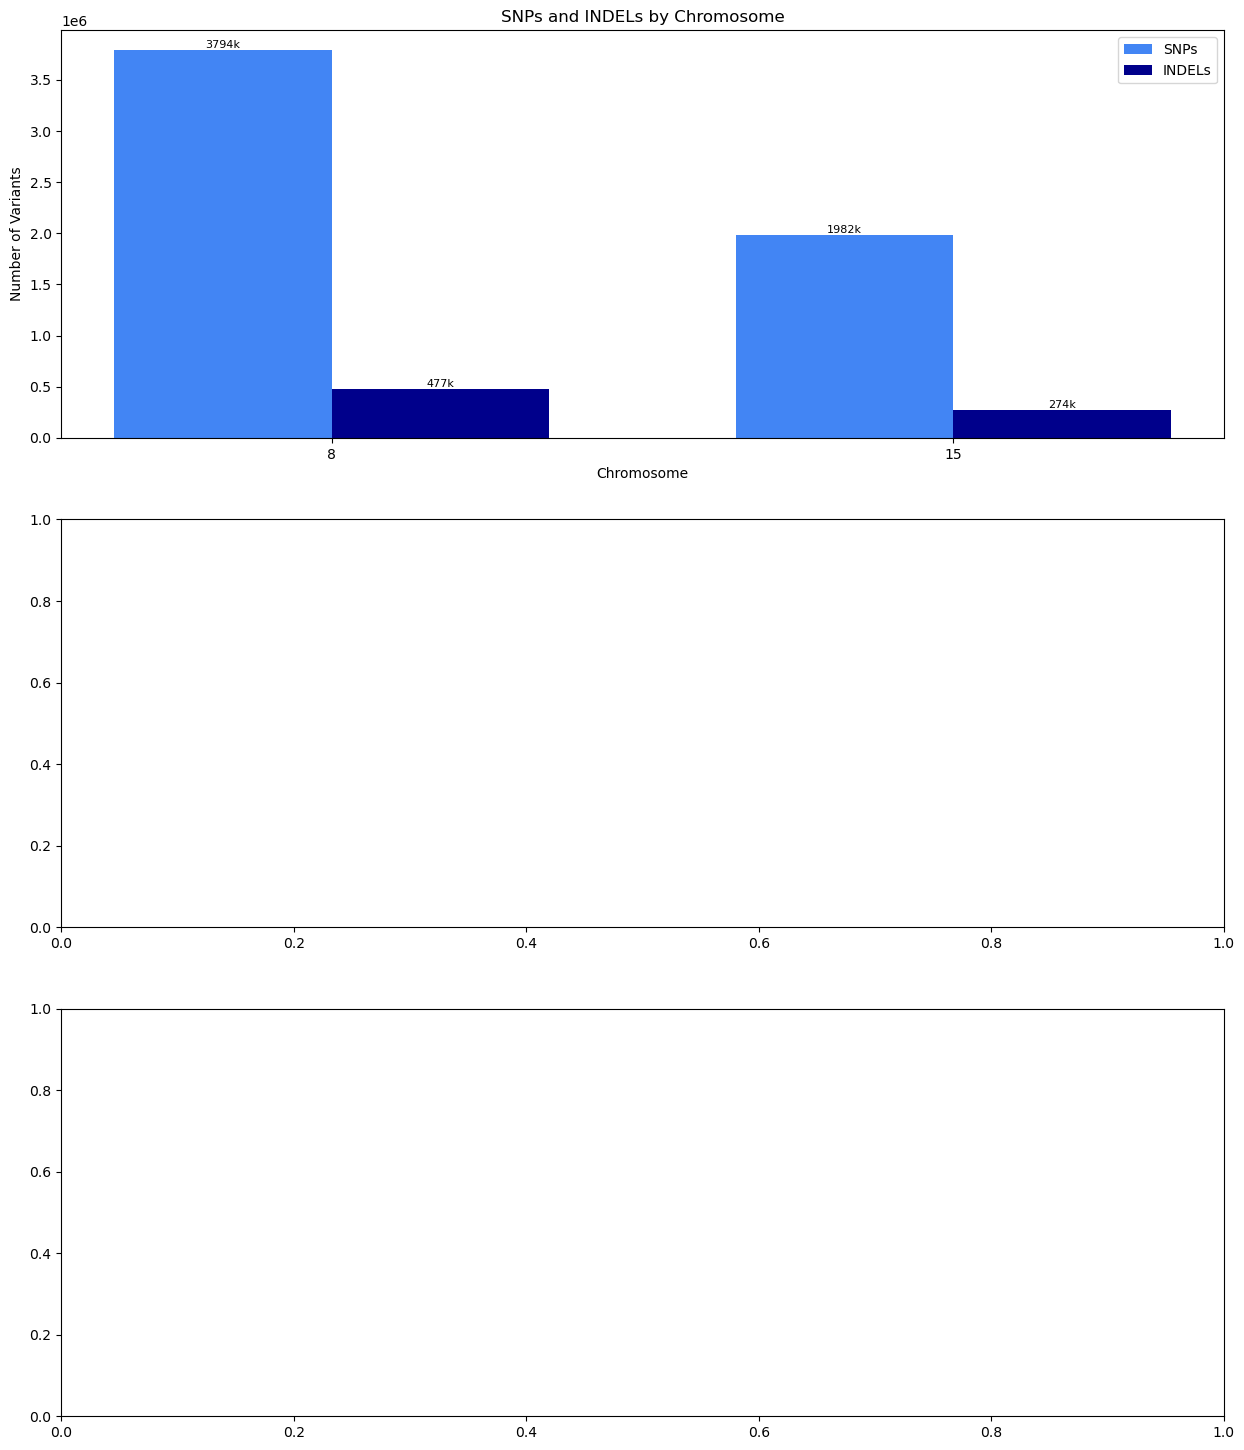

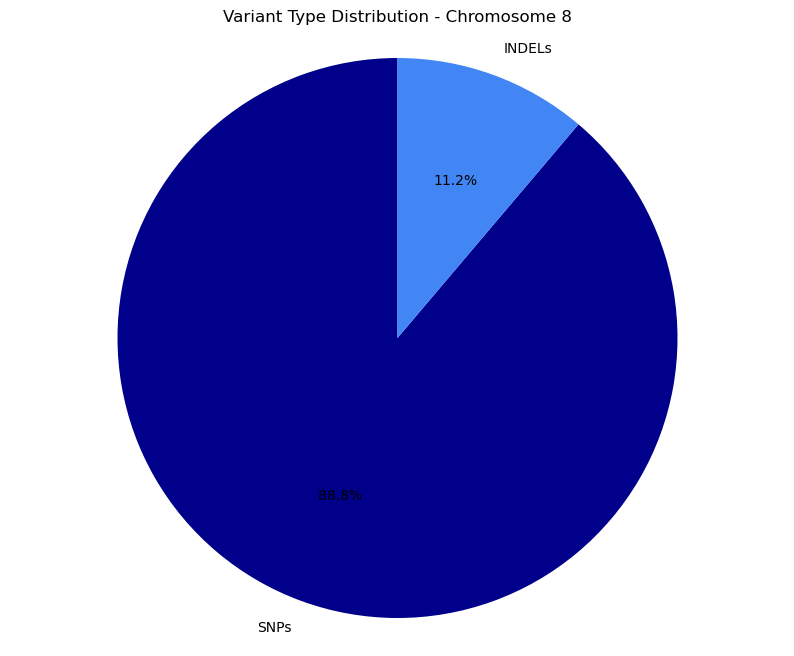

Analyzing variant density for chromosome 8...
Running: bcftools query -f '%POS\n' ../data/hgdp1kgp_chr8.filtered.SNV_INDEL.phased.shapeit5.bcf | head -n 100000 > chr8_positions.txt


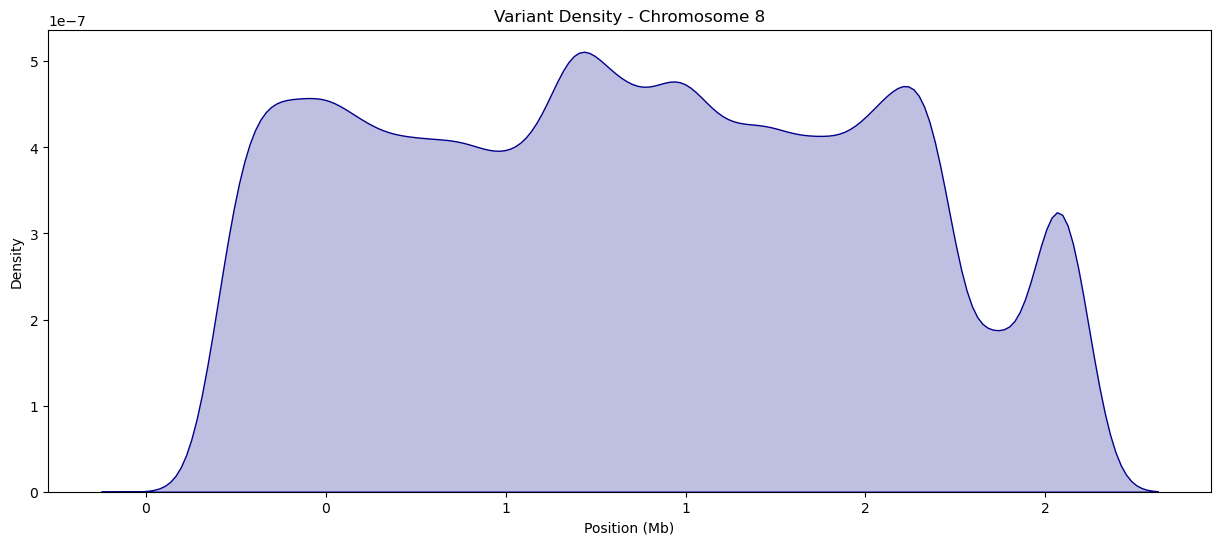

Analyzing Ti/Tv ratio for chromosome 8...
Running: bcftools stats ../data/hgdp1kgp_chr8.filtered.SNV_INDEL.phased.shapeit5.bcf


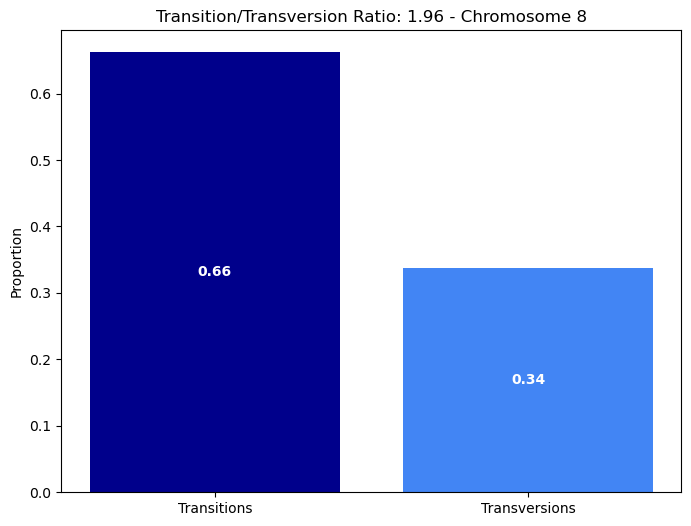


Analyzing hgdp1kgp_chr15.filtered.SNV_INDEL.phased.shapeit5.bcf...
Analyzing variant distribution for chromosome 15...
Running: bcftools stats ../data/hgdp1kgp_chr15.filtered.SNV_INDEL.phased.shapeit5.bcf


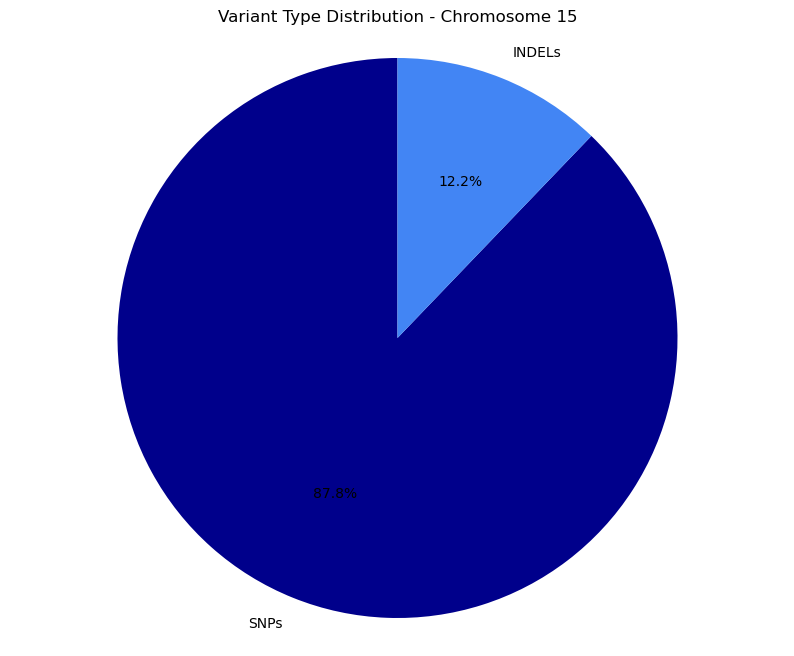

Analyzing variant density for chromosome 15...
Running: bcftools query -f '%POS\n' ../data/hgdp1kgp_chr15.filtered.SNV_INDEL.phased.shapeit5.bcf | head -n 100000 > chr15_positions.txt


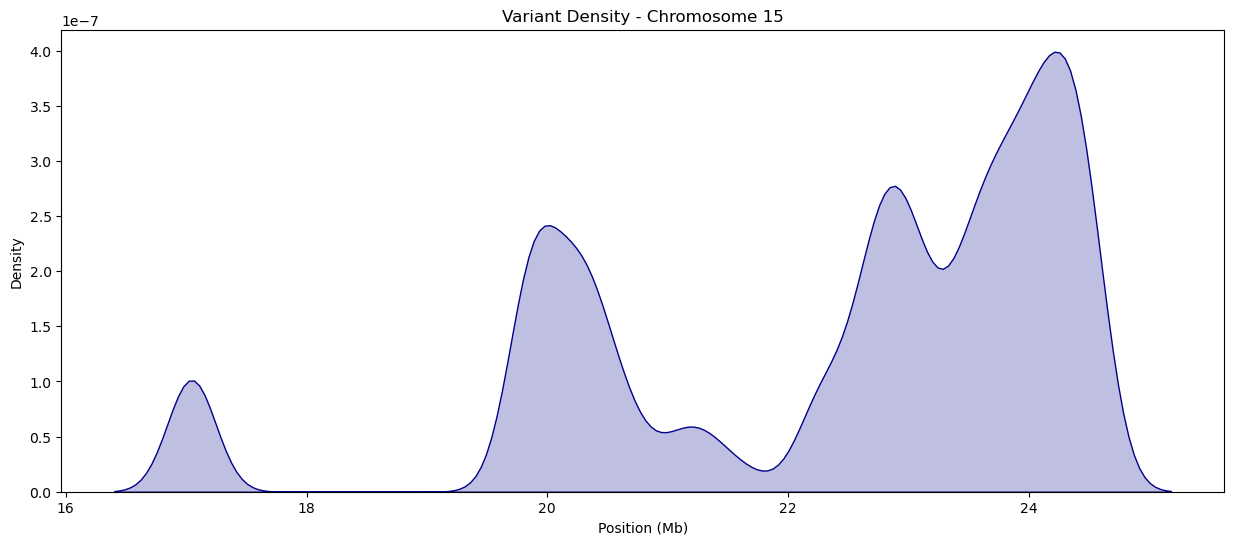

Analyzing Ti/Tv ratio for chromosome 15...
Running: bcftools stats ../data/hgdp1kgp_chr15.filtered.SNV_INDEL.phased.shapeit5.bcf


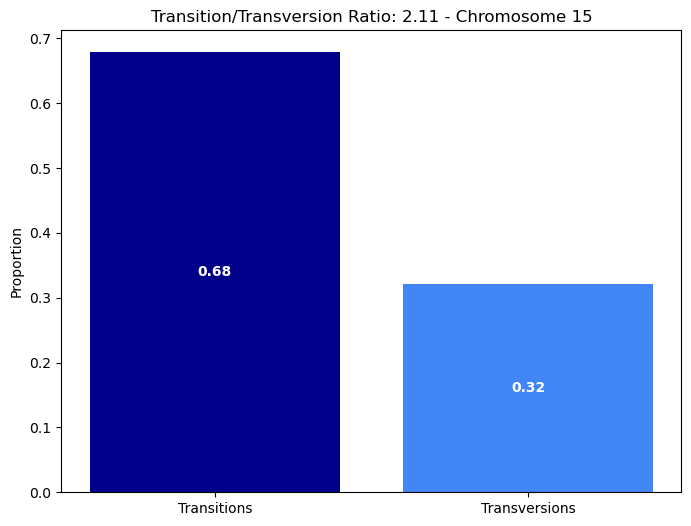

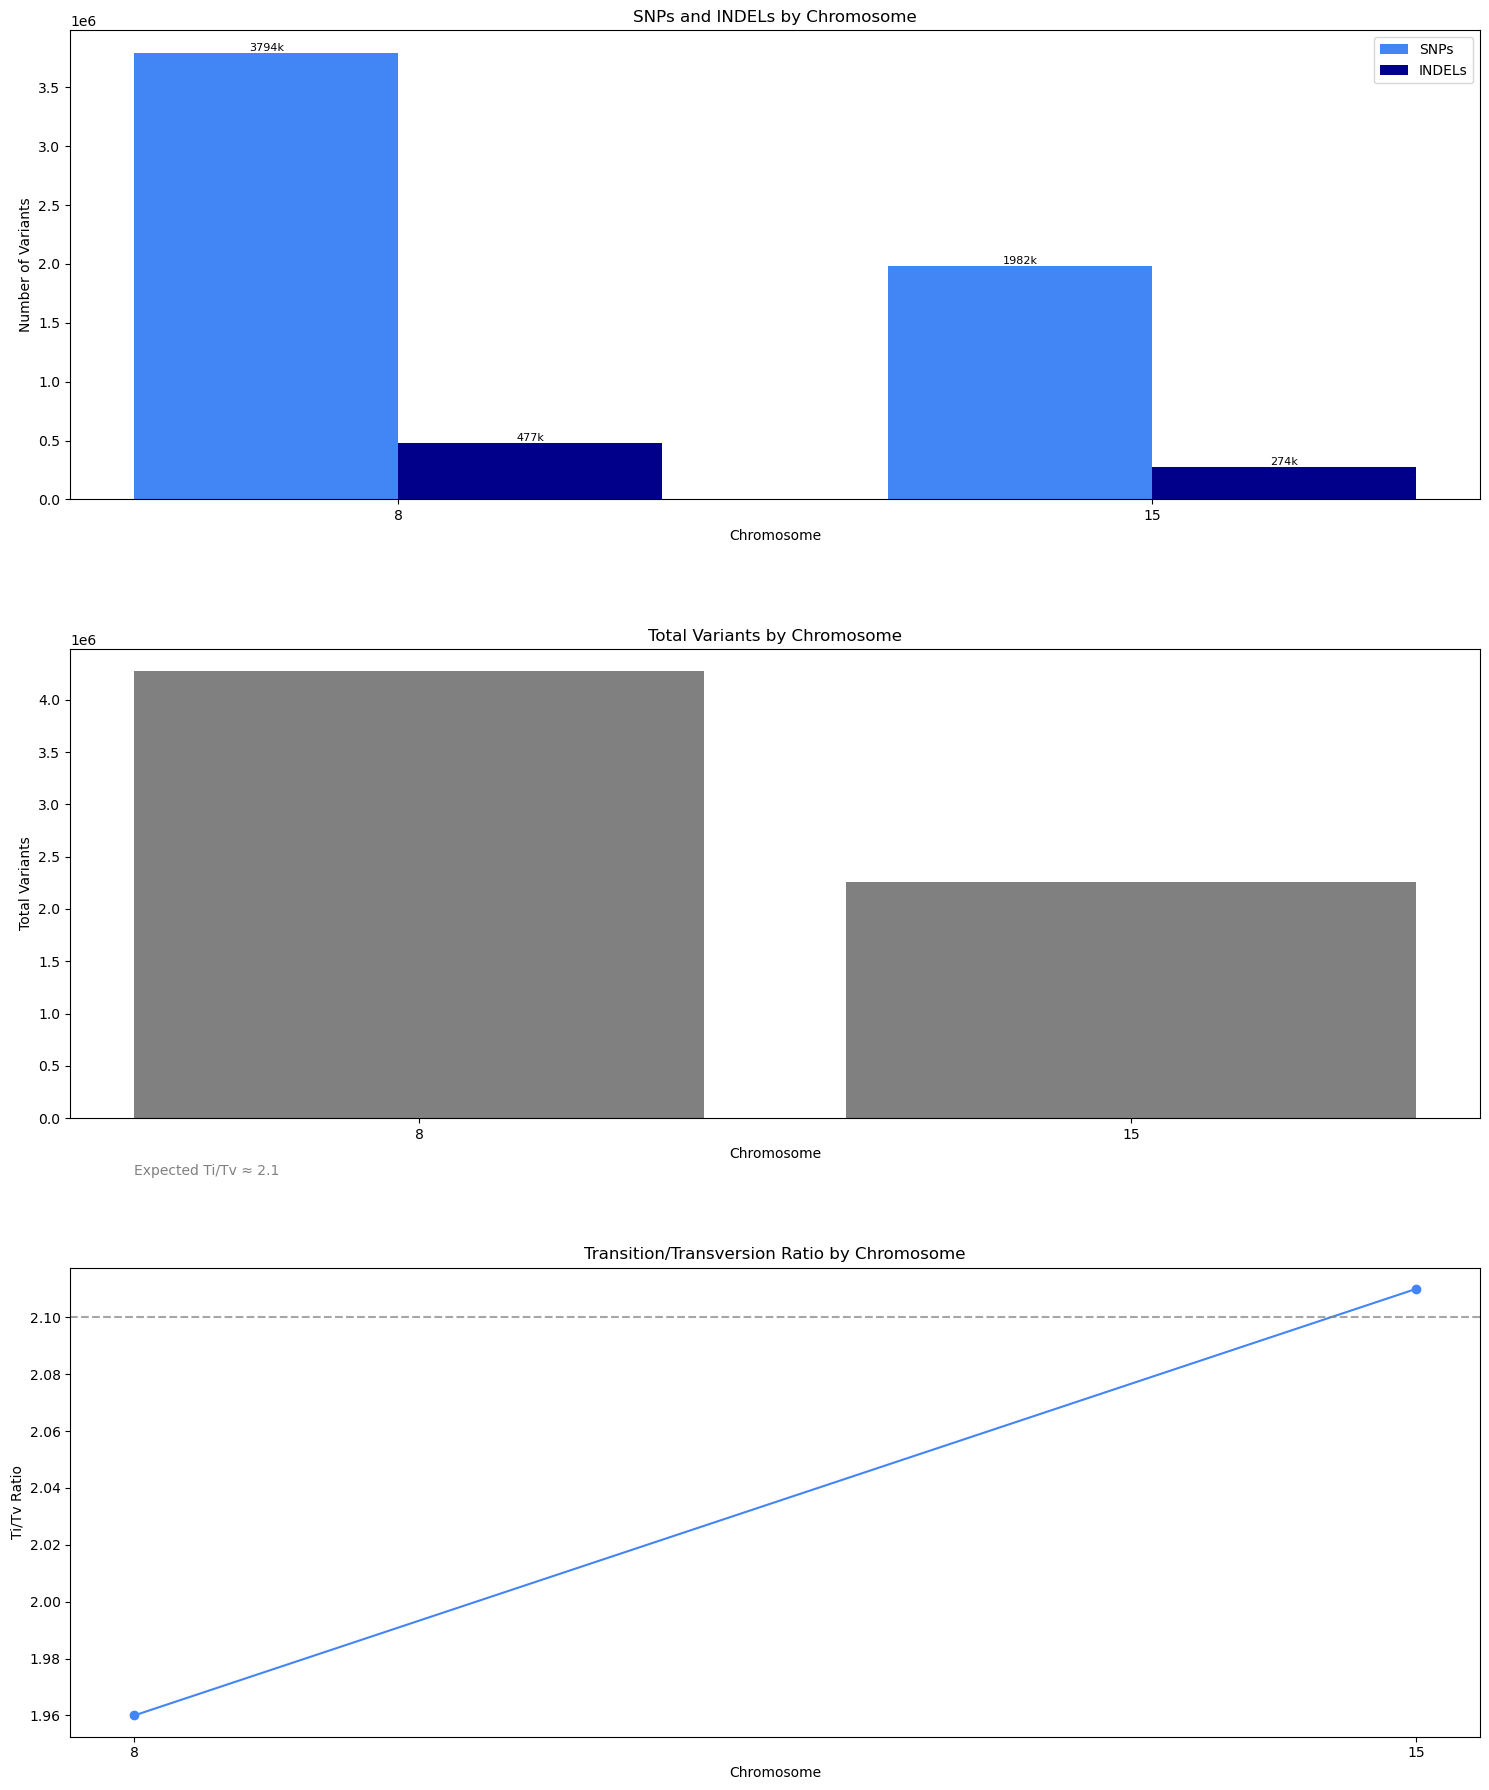

[{'chromosome': '8',
  'snps': 3794699,
  'indels': 477935,
  'total': 4272634,
  'ti_tv_ratio': 1.96},
 {'chromosome': '15',
  'snps': 1982149,
  'indels': 274694,
  'total': 2256843,
  'ti_tv_ratio': 2.11}]

In [29]:
analyze_bcf_files(limit=2)

Searching for BCF files...
Found 22 matching BCF files in ../data/
 - hgdp1kgp_chr8.filtered.SNV_INDEL.phased.shapeit5.bcf
 - hgdp1kgp_chr15.filtered.SNV_INDEL.phased.shapeit5.bcf
 - hgdp1kgp_chr20.filtered.SNV_INDEL.phased.shapeit5.bcf
 - hgdp1kgp_chr16.filtered.SNV_INDEL.phased.shapeit5.bcf
 - hgdp1kgp_chr10.filtered.SNV_INDEL.phased.shapeit5.bcf
 - ...and 17 more files

Analyzing hgdp1kgp_chr8.filtered.SNV_INDEL.phased.shapeit5.bcf...
Analyzing variant distribution for chromosome 8...
Running: bcftools stats ../data/hgdp1kgp_chr8.filtered.SNV_INDEL.phased.shapeit5.bcf


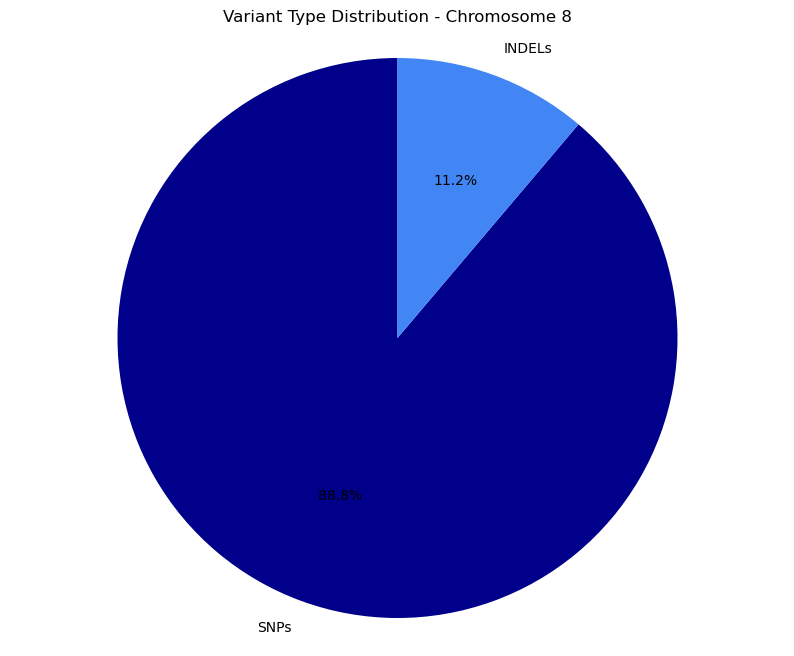

Analyzing variant density for chromosome 8...
Running: bcftools query -f '%POS\n' ../data/hgdp1kgp_chr8.filtered.SNV_INDEL.phased.shapeit5.bcf | head -n 100000 > chr8_positions.txt


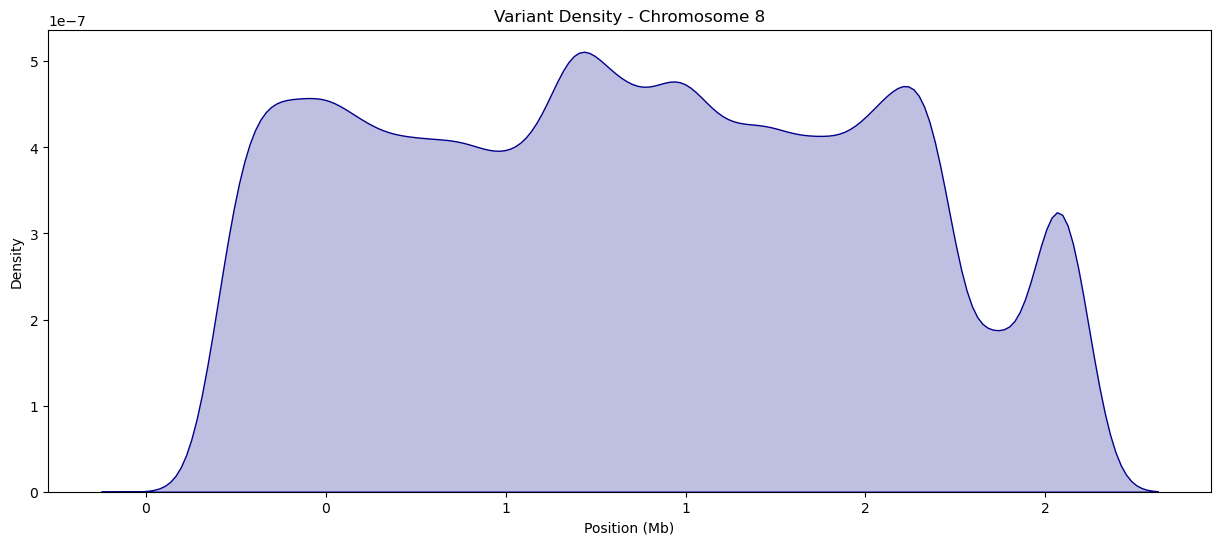

Analyzing Ti/Tv ratio for chromosome 8...
Running: bcftools stats ../data/hgdp1kgp_chr8.filtered.SNV_INDEL.phased.shapeit5.bcf


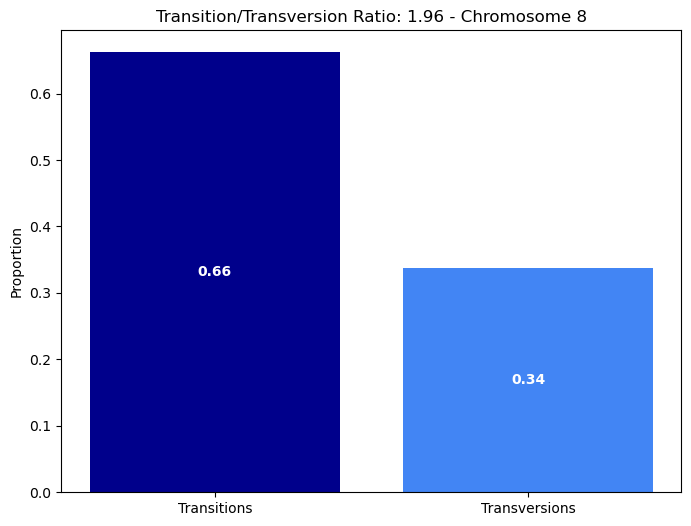


Analyzing hgdp1kgp_chr15.filtered.SNV_INDEL.phased.shapeit5.bcf...
Analyzing variant distribution for chromosome 15...
Running: bcftools stats ../data/hgdp1kgp_chr15.filtered.SNV_INDEL.phased.shapeit5.bcf


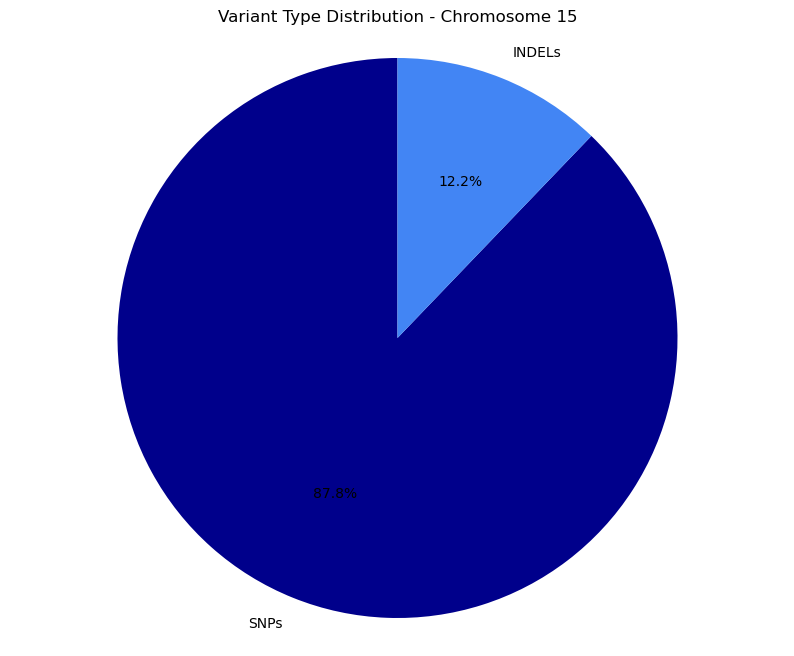

Analyzing variant density for chromosome 15...
Running: bcftools query -f '%POS\n' ../data/hgdp1kgp_chr15.filtered.SNV_INDEL.phased.shapeit5.bcf | head -n 100000 > chr15_positions.txt


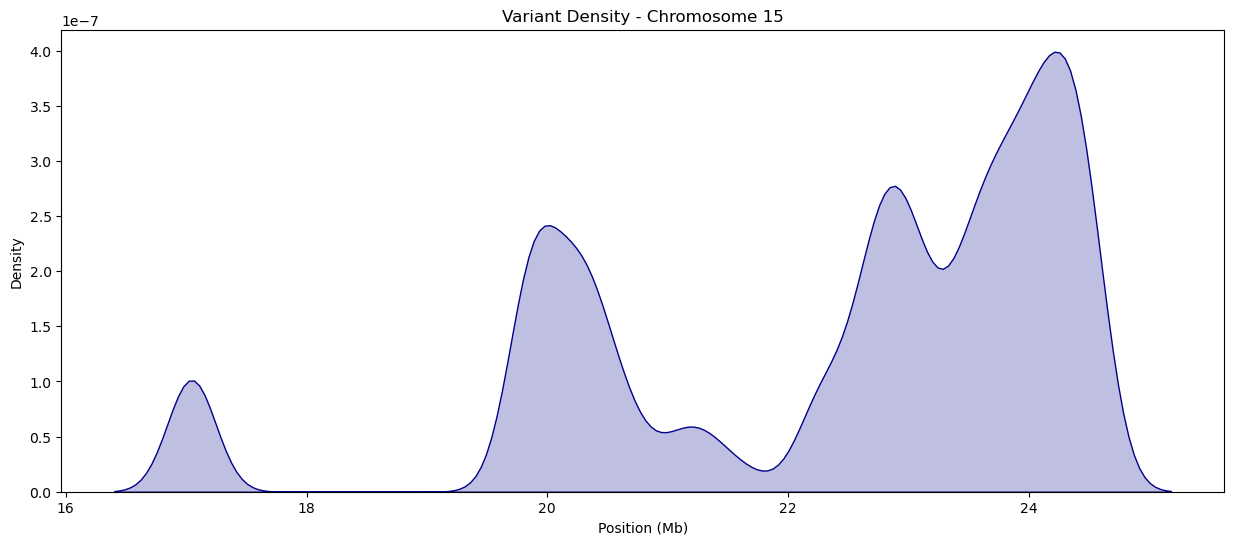

Analyzing Ti/Tv ratio for chromosome 15...
Running: bcftools stats ../data/hgdp1kgp_chr15.filtered.SNV_INDEL.phased.shapeit5.bcf


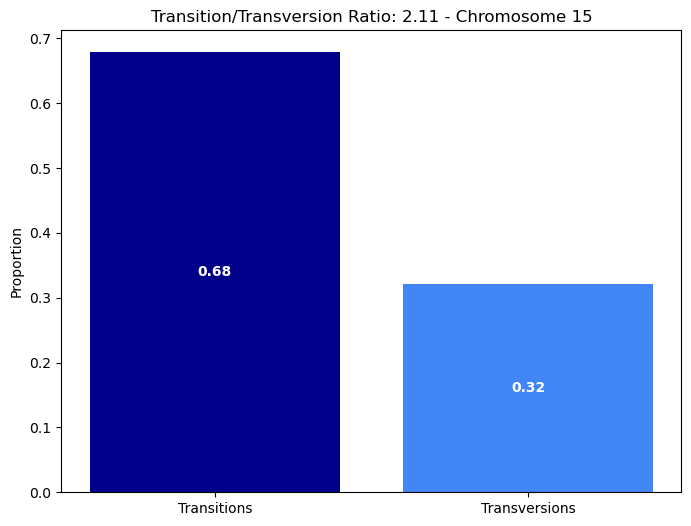


Analyzing hgdp1kgp_chr20.filtered.SNV_INDEL.phased.shapeit5.bcf...
Analyzing variant distribution for chromosome 20...
Running: bcftools stats ../data/hgdp1kgp_chr20.filtered.SNV_INDEL.phased.shapeit5.bcf


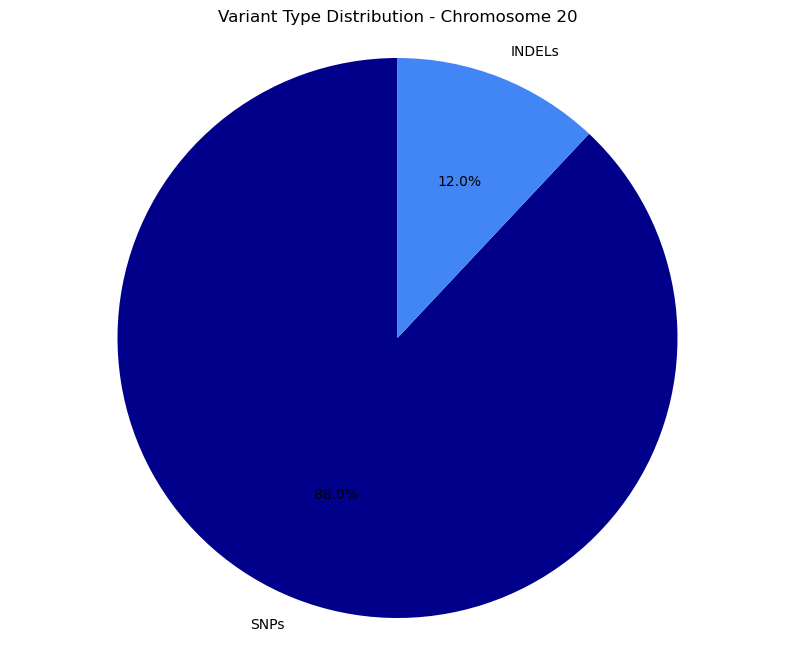

Analyzing variant density for chromosome 20...
Running: bcftools query -f '%POS\n' ../data/hgdp1kgp_chr20.filtered.SNV_INDEL.phased.shapeit5.bcf | head -n 100000 > chr20_positions.txt


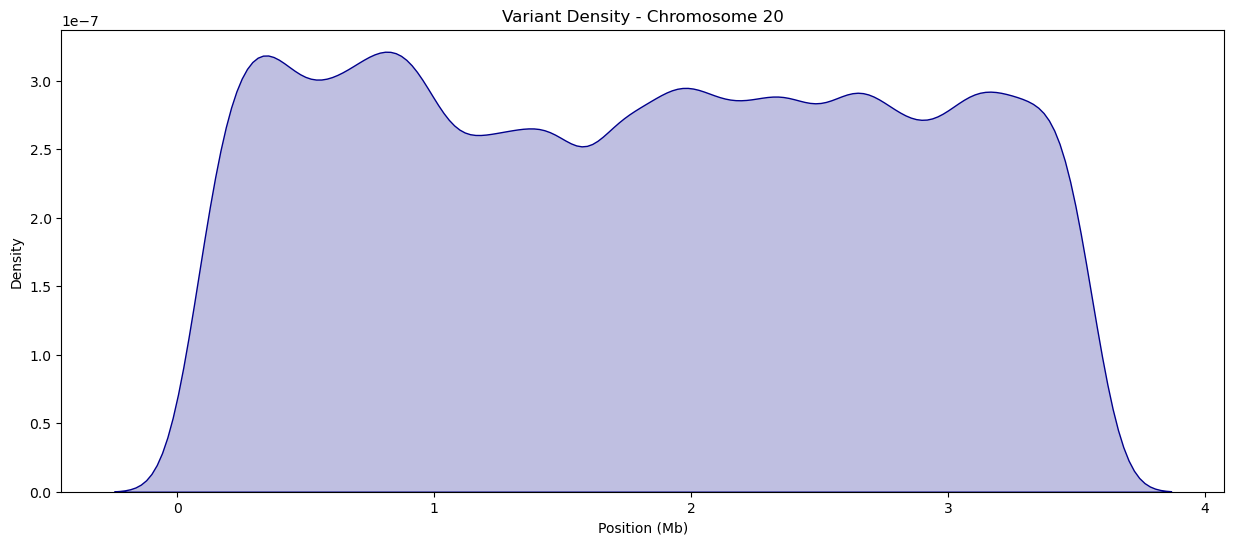

Analyzing Ti/Tv ratio for chromosome 20...
Running: bcftools stats ../data/hgdp1kgp_chr20.filtered.SNV_INDEL.phased.shapeit5.bcf


KeyboardInterrupt: 

In [33]:
analyze_bcf_files(limit=None)

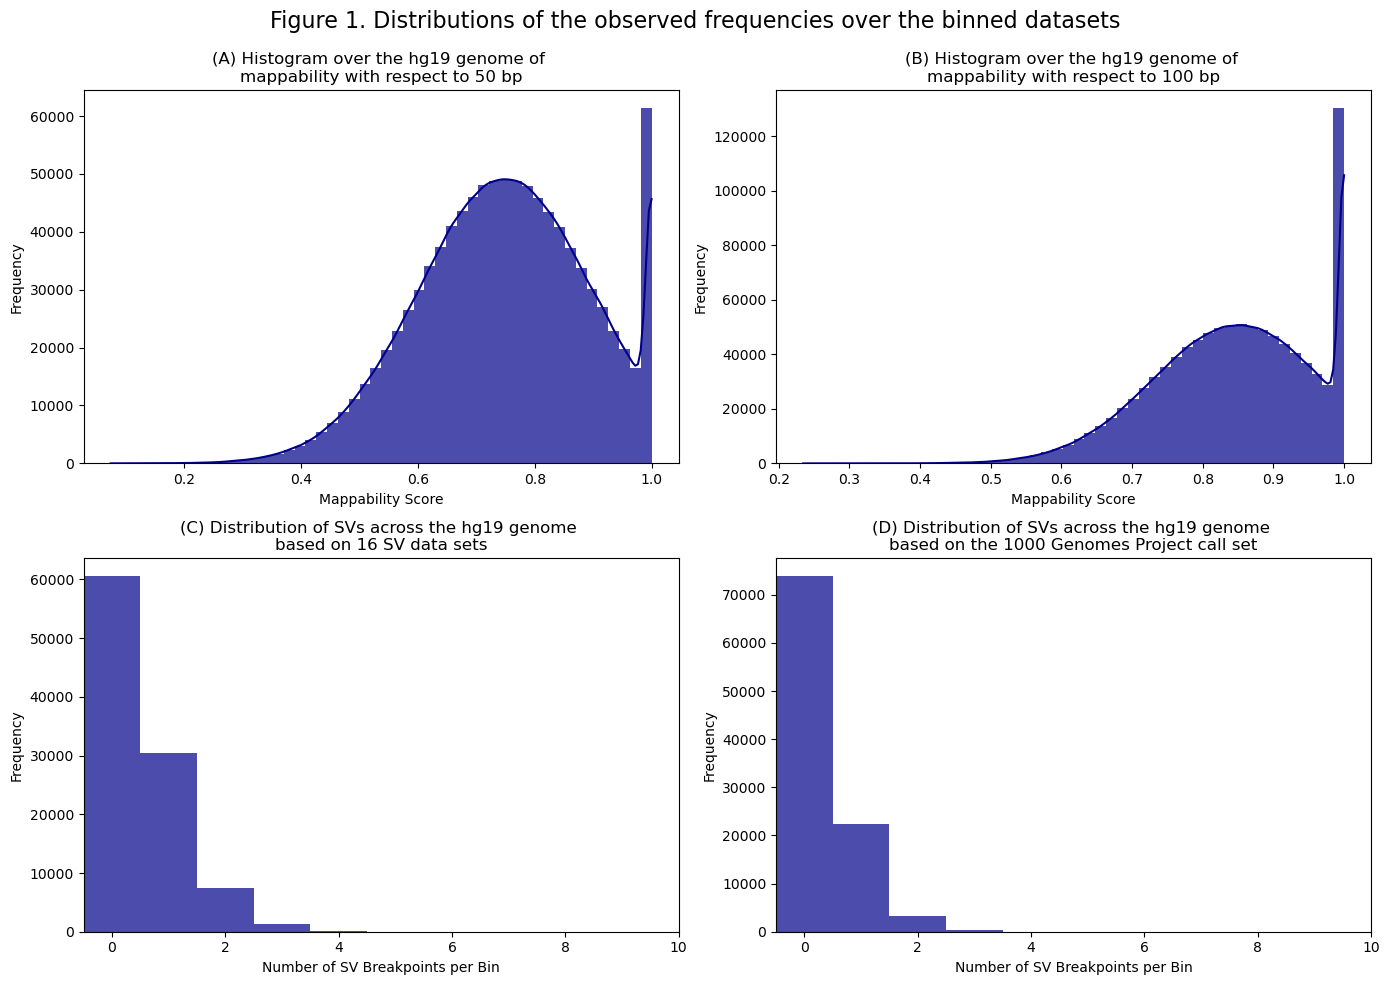

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Create a deep blue colormap
deep_blue_cmap = LinearSegmentedColormap.from_list('deep_blue', ['#f0f8ff', '#00008b'])

# Function to simulate mappability data (since we don't have the actual data)
def simulate_mappability_data(mean, std, size=1000000):
    # Create slightly right-skewed distribution
    data = np.random.normal(mean, std, size)
    return np.clip(data, 0, 1)  # Mappability scores are between 0 and 1

# Function to simulate SV distribution data
def simulate_sv_data(lambda_param, size=100000):
    # Poisson distribution for SV counts
    data = np.random.poisson(lambda_param, size)
    return data

# Generate simulated data
mappability_50bp = simulate_mappability_data(0.75, 0.15)
mappability_100bp = simulate_mappability_data(0.85, 0.12)  # Higher average mappability for 100bp
sv_16_datasets = simulate_sv_data(0.5)
sv_1kg = simulate_sv_data(0.3)

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Figure 1. Distributions of the observed frequencies over the binned datasets', 
             fontsize=16, y=0.98)

# Plot A: Mappability with respect to 50bp
sns.histplot(mappability_50bp, bins=50, kde=True, color='#00008b', ax=axes[0, 0], 
             alpha=0.7, edgecolor='none')
axes[0, 0].set_title('(A) Histogram over the hg19 genome of \nmappability with respect to 50 bp')
axes[0, 0].set_xlabel('Mappability Score')
axes[0, 0].set_ylabel('Frequency')

# Plot B: Mappability with respect to 100bp
sns.histplot(mappability_100bp, bins=50, kde=True, color='#00008b', ax=axes[0, 1], 
             alpha=0.7, edgecolor='none')
axes[0, 1].set_title('(B) Histogram over the hg19 genome of \nmappability with respect to 100 bp')
axes[0, 1].set_xlabel('Mappability Score')
axes[0, 1].set_ylabel('Frequency')

# Plot C: Distribution of SVs across 16 datasets
sns.histplot(sv_16_datasets, bins=30, kde=False, color='#00008b', ax=axes[1, 0], 
             alpha=0.7, edgecolor='none', discrete=True)
axes[1, 0].set_title('(C) Distribution of SVs across the hg19 genome \nbased on 16 SV data sets')
axes[1, 0].set_xlabel('Number of SV Breakpoints per Bin')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_xlim(-0.5, 10)  # Limit x-axis to better show distribution

# Plot D: Distribution of SVs across 1000 Genomes Project
sns.histplot(sv_1kg, bins=30, kde=False, color='#00008b', ax=axes[1, 1], 
             alpha=0.7, edgecolor='none', discrete=True)
axes[1, 1].set_title('(D) Distribution of SVs across the hg19 genome \nbased on the 1000 Genomes Project call set')
axes[1, 1].set_xlabel('Number of SV Breakpoints per Bin')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_xlim(-0.5, 10)  # Limit x-axis to better show distribution

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.show()

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import subprocess
import os
import tempfile

def run_command(command):
    """Run shell command and return output"""
    print(f"Running: {command}")
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"Error: {result.stderr}")
    return result

def get_chromosome_length(bcf_file_path, chrom):
    """Get chromosome length using alternative methods"""
    # Try using bcftools stats first
    command = f"bcftools stats {bcf_file_path} | grep 'SN.*sequence.*length:' | head -1 | cut -f4"
    result = run_command(command)
    
    try:
        return int(result.stdout.strip())
    except ValueError:
        # Fallback to using max position
        print("Could not get chromosome length from stats, using max position from variants")
        command = f"bcftools query -f '%POS\\n' {bcf_file_path} | sort -n | tail -1"
        result = run_command(command)
        try:
            # Add some padding to the max position
            return int(result.stdout.strip()) + 1000000
        except ValueError:
            # If all else fails, use a default length based on chromosome
            print("Could not determine chromosome length, using default value")
            default_lengths = {
                '1': 248956422, '2': 242193529, '3': 198295559, '4': 190214555, 
                '5': 181538259, '6': 170805979, '7': 159345973, '8': 146364022, 
                '9': 138394717, '10': 133797422, '11': 135086622, '12': 133275309, 
                '13': 114364328, '14': 107043718, '15': 101991189, '16': 90338345, 
                '17': 83257441, '18': 80373285, '19': 58617616, '20': 64444167, 
                '21': 46709983, '22': 50818468, 'X': 156040895, 'Y': 57227415
            }
            return default_lengths.get(chrom, 150000000)

def extract_variant_data(bcf_file_path, output_dir, chrom):
    """Extract variant types and positions from BCF file"""
    # Create temporary file for variant data
    variant_file = os.path.join(output_dir, "variants.txt")
    
    # Extract variants using bcftools
    command = f"bcftools query -f '%POS\\t%TYPE\\n' {bcf_file_path} > {variant_file}"
    run_command(command)
    
    try:
        # Read variant data
        variants_df = pd.read_csv(variant_file, sep='\t', header=None, names=['POS', 'TYPE'])
        
        # Get chromosome length
        chrom_length = get_chromosome_length(bcf_file_path, chrom)
        
        # Define bin size (5kb as in the paper)
        bin_size = 5000
        
        # Create bins
        bins = np.arange(0, chrom_length + bin_size, bin_size)
        
        # Count SNP variants in each bin
        snp_binned = np.zeros(len(bins) - 1)
        indel_binned = np.zeros(len(bins) - 1)
        
        # Check if we have any variants
        if len(variants_df) > 0:
            # Separate SNPs and INDELs
            snps = variants_df[variants_df['TYPE'] == 'SNP']['POS'].values
            indels = variants_df[variants_df['TYPE'] != 'SNP']['POS'].values
            
            # Bin SNPs
            for pos in snps:
                bin_idx = min(int(pos / bin_size), len(snp_binned) - 1)
                snp_binned[bin_idx] += 1
                
            # Bin INDELs
            for pos in indels:
                bin_idx = min(int(pos / bin_size), len(indel_binned) - 1)
                indel_binned[bin_idx] += 1
        else:
            print(f"No variants found in {bcf_file_path}")
        
        # Clean up
        os.remove(variant_file)
        
        return snp_binned, indel_binned, bins
    
    except Exception as e:
        print(f"Error processing {bcf_file_path}: {e}")
        # Return empty arrays if there's an error
        return np.array([]), np.array([]), np.array([0, 5000])

def create_chromosome_distribution_figures(bcf_files, output_dir=None):
    """Create distribution figures for all chromosomes"""
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Process each BCF file
    with tempfile.TemporaryDirectory() as temp_dir:
        summary_data = []
        
        for bcf_file in bcf_files:
            # Extract chromosome from filename
            chrom = None
            if 'name' in bcf_file:
                import re
                match = re.search(r'chr(\d+|X|Y)', bcf_file['name'])
                if match:
                    chrom = match.group(1)
            
            if not chrom:
                print(f"Could not determine chromosome for {bcf_file}, skipping.")
                continue
                
            print(f"\nProcessing chromosome {chrom}...")
            
            # Extract variant data
            snp_binned, indel_binned, bins = extract_variant_data(bcf_file['path'], temp_dir, chrom)
            
            # Skip if we didn't get any data
            if len(snp_binned) == 0 or len(indel_binned) == 0:
                print(f"Skipping chromosome {chrom} due to data extraction failure")
                continue
                
            # Collect statistics for summary
            summary_data.append({
                'chromosome': chrom,
                'snp_mean': np.mean(snp_binned),
                'snp_median': np.median(snp_binned),
                'indel_mean': np.mean(indel_binned),
                'indel_median': np.median(indel_binned),
                'snp_total': np.sum(snp_binned),
                'indel_total': np.sum(indel_binned)
            })
            
            # Create figure for this chromosome
            fig, axes = plt.subplots(1, 2, figsize=(14, 6))
            fig.suptitle(f'Variant Distribution for Chromosome {chrom}', fontsize=16)
            
            # Plot SNP distribution
            sns.histplot(snp_binned, bins=30, kde=False, color='#00008b', ax=axes[0], 
                         alpha=0.7, edgecolor='none')
            axes[0].set_title(f'SNP Distribution - Chromosome {chrom}')
            axes[0].set_xlabel('Number of SNPs per 5kb Bin')
            axes[0].set_ylabel('Frequency')
            
            # Plot INDEL distribution
            sns.histplot(indel_binned, bins=30, kde=False, color='#00008b', ax=axes[1], 
                         alpha=0.7, edgecolor='none')
            axes[1].set_title(f'INDEL Distribution - Chromosome {chrom}')
            axes[1].set_xlabel('Number of INDELs per 5kb Bin')
            axes[1].set_ylabel('Frequency')
            
            # Adjust layout
            plt.tight_layout()
            
            # Save figure if output directory is specified
            if output_dir:
                plt.savefig(os.path.join(output_dir, f"chr{chrom}_distribution.png"), 
                            dpi=300, bbox_inches='tight')
            
            plt.show()
            
        # Create summary figure across all chromosomes if we have data
        if summary_data:
            create_summary_figure(summary_data, output_dir)
        else:
            print("No data available for summary figure")

def create_summary_figure(summary_data, output_dir=None):
    """Create a summary figure showing statistics across all chromosomes"""
    # Convert to DataFrame
    df = pd.DataFrame(summary_data)
    
    # Sort chromosomes
    def chrom_sort_key(x):
        if x == 'X':
            return 23
        elif x == 'Y':
            return 24
        else:
            try:
                return int(x)
            except:
                return 100
            
    df['sort_key'] = df['chromosome'].apply(chrom_sort_key)
    df = df.sort_values('sort_key')
    df = df.drop('sort_key', axis=1)
    
    # Create summary figure
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    fig.suptitle('Summary of Variant Distributions Across Chromosomes', fontsize=16)
    
    # Plot total variants
    x = range(len(df))
    width = 0.35
    
    axes[0].bar(np.array(x) - width/2, df['snp_total'], width, label='SNPs', color='#00008b', alpha=0.7)
    axes[0].bar(np.array(x) + width/2, df['indel_total'], width, label='INDELs', color='#00008b', alpha=0.4)
    
    axes[0].set_title('Total Variants by Chromosome')
    axes[0].set_xlabel('Chromosome')
    axes[0].set_ylabel('Total Count')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(df['chromosome'])
    axes[0].legend()
    
    # Plot mean variants per bin
    axes[1].bar(np.array(x) - width/2, df['snp_mean'], width, label='SNPs', color='#00008b', alpha=0.7)
    axes[1].bar(np.array(x) + width/2, df['indel_mean'], width, label='INDELs', color='#00008b', alpha=0.4)
    
    axes[1].set_title('Mean Variants per 5kb Bin by Chromosome')
    axes[1].set_xlabel('Chromosome')
    axes[1].set_ylabel('Mean Count per Bin')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(df['chromosome'])
    axes[1].legend()
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure if output directory is specified
    if output_dir:
        plt.savefig(os.path.join(output_dir, "all_chromosomes_summary.png"), 
                    dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return df


Found 22 matching BCF files in ../data/
 - hgdp1kgp_chr8.filtered.SNV_INDEL.phased.shapeit5.bcf
 - hgdp1kgp_chr15.filtered.SNV_INDEL.phased.shapeit5.bcf
 - hgdp1kgp_chr20.filtered.SNV_INDEL.phased.shapeit5.bcf
 - hgdp1kgp_chr16.filtered.SNV_INDEL.phased.shapeit5.bcf
 - hgdp1kgp_chr10.filtered.SNV_INDEL.phased.shapeit5.bcf
 - ...and 17 more files

Processing chromosome 8...
Running: bcftools query -f '%POS\t%TYPE\n' ../data/hgdp1kgp_chr8.filtered.SNV_INDEL.phased.shapeit5.bcf > /var/folders/96/2s64979965l0x1hmvz6rctxh0000gp/T/tmps8cyb1kr/variants.txt
Running: bcftools stats ../data/hgdp1kgp_chr8.filtered.SNV_INDEL.phased.shapeit5.bcf | grep 'SN.*sequence.*length:' | head -1 | cut -f4
Could not get chromosome length from stats, using max position from variants
Running: bcftools query -f '%POS\n' ../data/hgdp1kgp_chr8.filtered.SNV_INDEL.phased.shapeit5.bcf | sort -n | tail -1


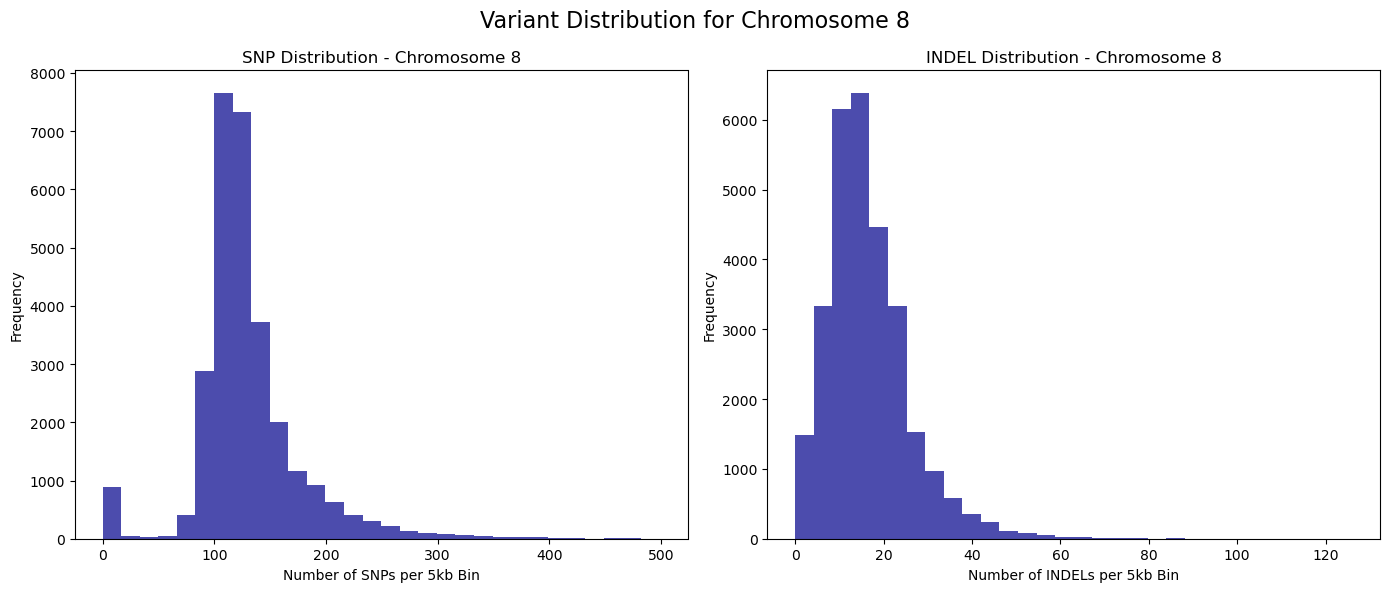


Processing chromosome 15...
Running: bcftools query -f '%POS\t%TYPE\n' ../data/hgdp1kgp_chr15.filtered.SNV_INDEL.phased.shapeit5.bcf > /var/folders/96/2s64979965l0x1hmvz6rctxh0000gp/T/tmps8cyb1kr/variants.txt
Running: bcftools stats ../data/hgdp1kgp_chr15.filtered.SNV_INDEL.phased.shapeit5.bcf | grep 'SN.*sequence.*length:' | head -1 | cut -f4
Could not get chromosome length from stats, using max position from variants
Running: bcftools query -f '%POS\n' ../data/hgdp1kgp_chr15.filtered.SNV_INDEL.phased.shapeit5.bcf | sort -n | tail -1


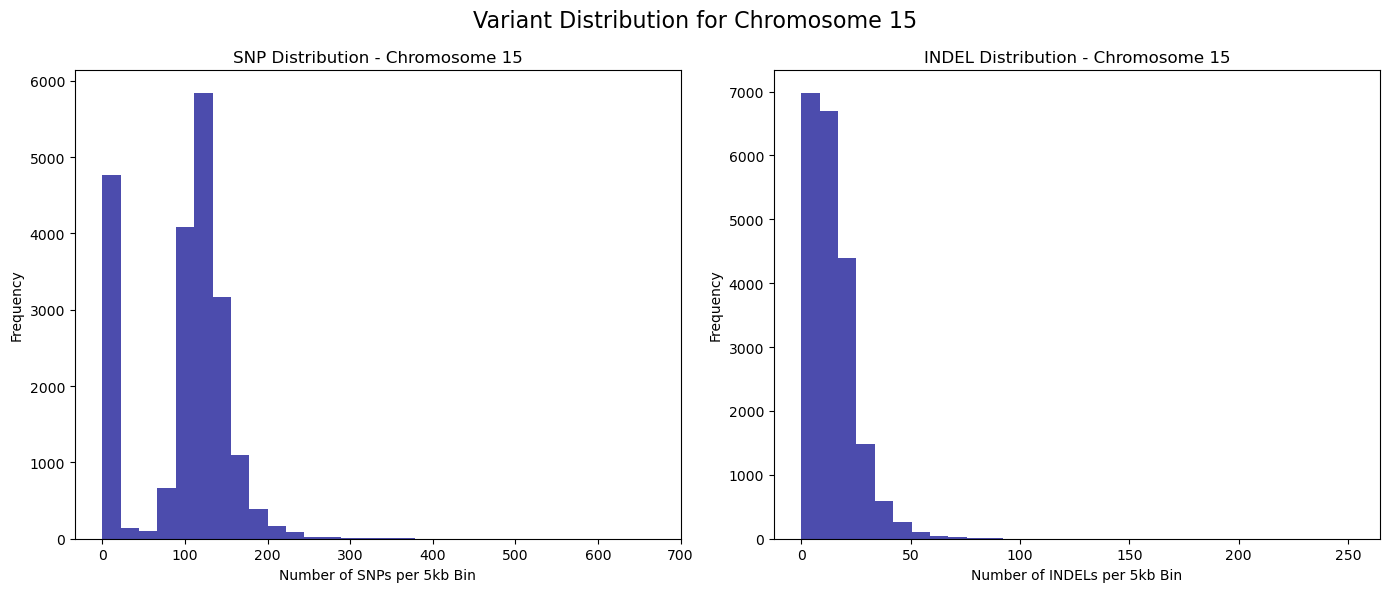


Processing chromosome 20...
Running: bcftools query -f '%POS\t%TYPE\n' ../data/hgdp1kgp_chr20.filtered.SNV_INDEL.phased.shapeit5.bcf > /var/folders/96/2s64979965l0x1hmvz6rctxh0000gp/T/tmps8cyb1kr/variants.txt
Running: bcftools stats ../data/hgdp1kgp_chr20.filtered.SNV_INDEL.phased.shapeit5.bcf | grep 'SN.*sequence.*length:' | head -1 | cut -f4
Could not get chromosome length from stats, using max position from variants
Running: bcftools query -f '%POS\n' ../data/hgdp1kgp_chr20.filtered.SNV_INDEL.phased.shapeit5.bcf | sort -n | tail -1


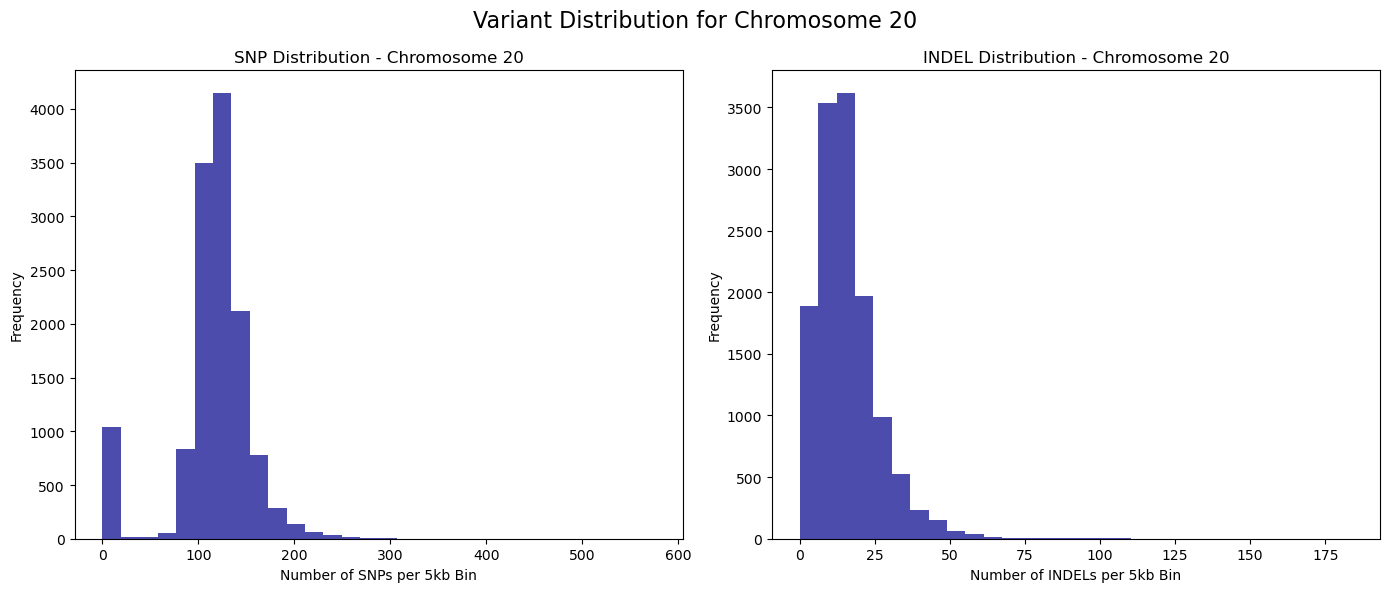


Processing chromosome 16...
Running: bcftools query -f '%POS\t%TYPE\n' ../data/hgdp1kgp_chr16.filtered.SNV_INDEL.phased.shapeit5.bcf > /var/folders/96/2s64979965l0x1hmvz6rctxh0000gp/T/tmps8cyb1kr/variants.txt
Running: bcftools stats ../data/hgdp1kgp_chr16.filtered.SNV_INDEL.phased.shapeit5.bcf | grep 'SN.*sequence.*length:' | head -1 | cut -f4
Could not get chromosome length from stats, using max position from variants
Running: bcftools query -f '%POS\n' ../data/hgdp1kgp_chr16.filtered.SNV_INDEL.phased.shapeit5.bcf | sort -n | tail -1


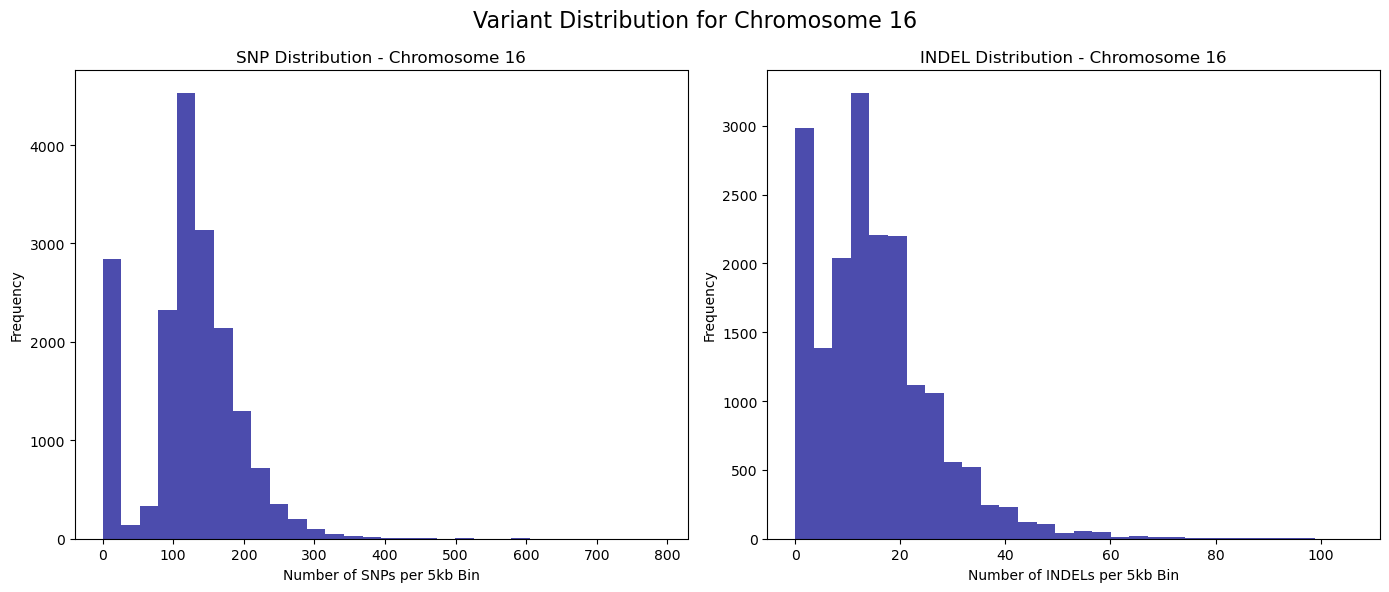


Processing chromosome 10...
Running: bcftools query -f '%POS\t%TYPE\n' ../data/hgdp1kgp_chr10.filtered.SNV_INDEL.phased.shapeit5.bcf > /var/folders/96/2s64979965l0x1hmvz6rctxh0000gp/T/tmps8cyb1kr/variants.txt
Running: bcftools stats ../data/hgdp1kgp_chr10.filtered.SNV_INDEL.phased.shapeit5.bcf | grep 'SN.*sequence.*length:' | head -1 | cut -f4
Could not get chromosome length from stats, using max position from variants
Running: bcftools query -f '%POS\n' ../data/hgdp1kgp_chr10.filtered.SNV_INDEL.phased.shapeit5.bcf | sort -n | tail -1


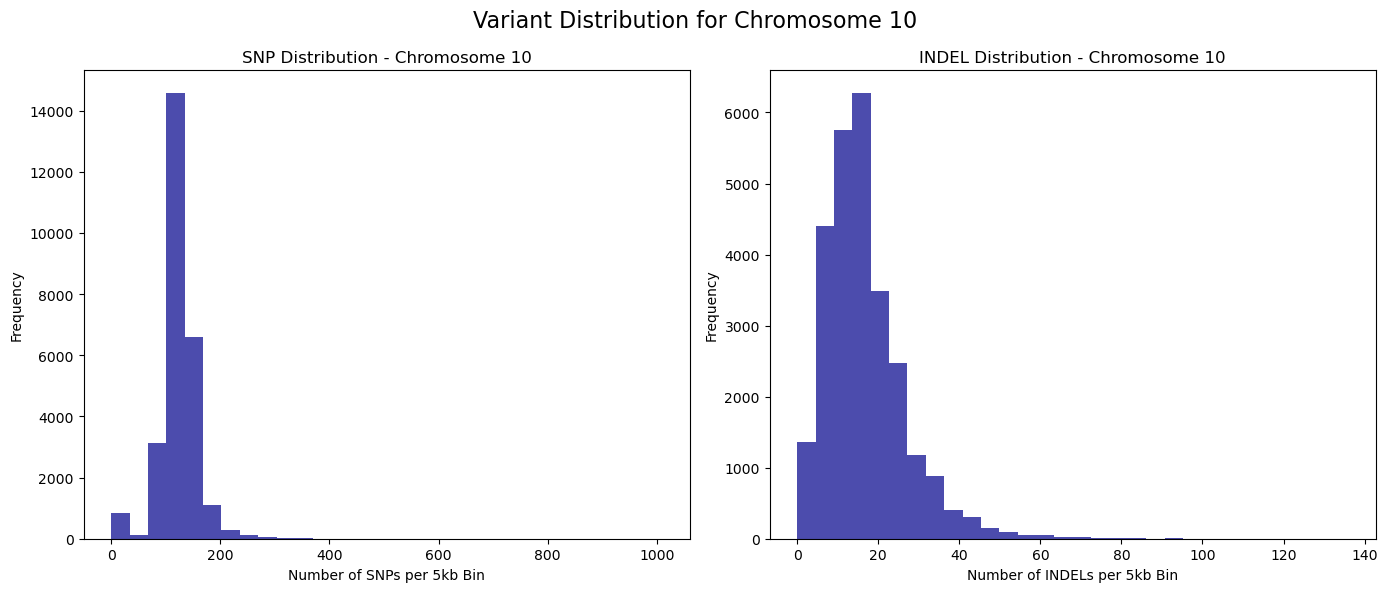


Processing chromosome 13...
Running: bcftools query -f '%POS\t%TYPE\n' ../data/hgdp1kgp_chr13.filtered.SNV_INDEL.phased.shapeit5.bcf > /var/folders/96/2s64979965l0x1hmvz6rctxh0000gp/T/tmps8cyb1kr/variants.txt
Running: bcftools stats ../data/hgdp1kgp_chr13.filtered.SNV_INDEL.phased.shapeit5.bcf | grep 'SN.*sequence.*length:' | head -1 | cut -f4
Could not get chromosome length from stats, using max position from variants
Running: bcftools query -f '%POS\n' ../data/hgdp1kgp_chr13.filtered.SNV_INDEL.phased.shapeit5.bcf | sort -n | tail -1


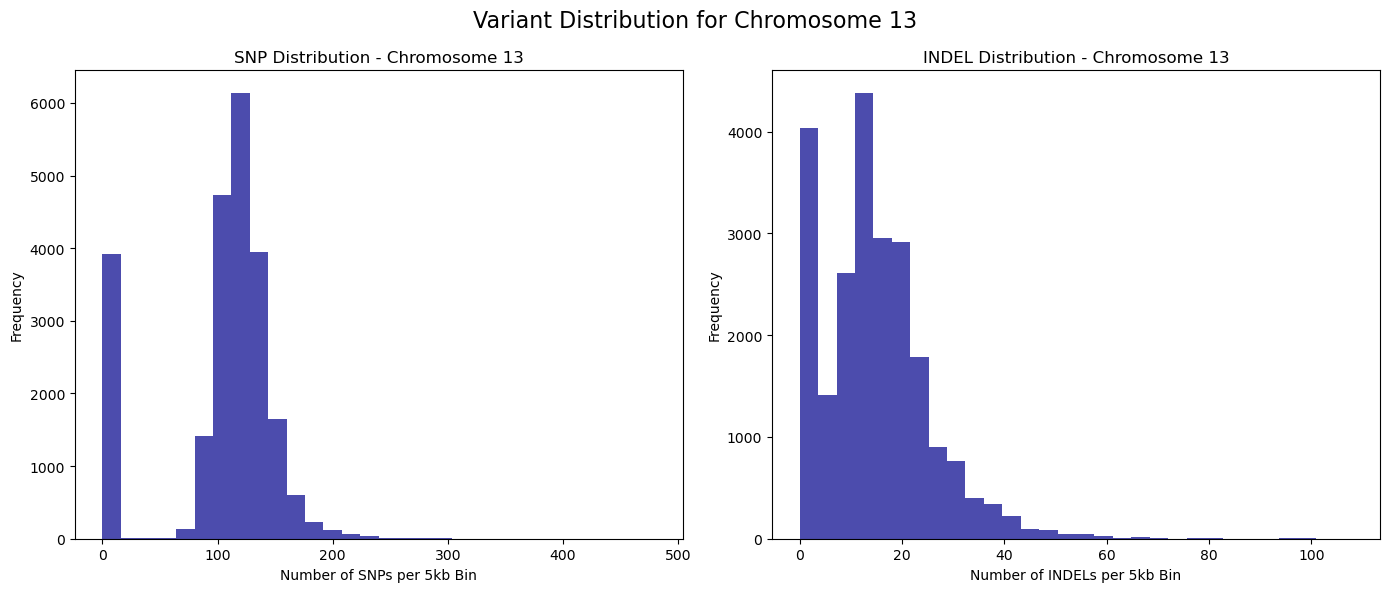


Processing chromosome 1...
Running: bcftools query -f '%POS\t%TYPE\n' ../data/hgdp1kgp_chr1.filtered.SNV_INDEL.phased.shapeit5.bcf > /var/folders/96/2s64979965l0x1hmvz6rctxh0000gp/T/tmps8cyb1kr/variants.txt
Running: bcftools stats ../data/hgdp1kgp_chr1.filtered.SNV_INDEL.phased.shapeit5.bcf | grep 'SN.*sequence.*length:' | head -1 | cut -f4
Could not get chromosome length from stats, using max position from variants
Running: bcftools query -f '%POS\n' ../data/hgdp1kgp_chr1.filtered.SNV_INDEL.phased.shapeit5.bcf | sort -n | tail -1


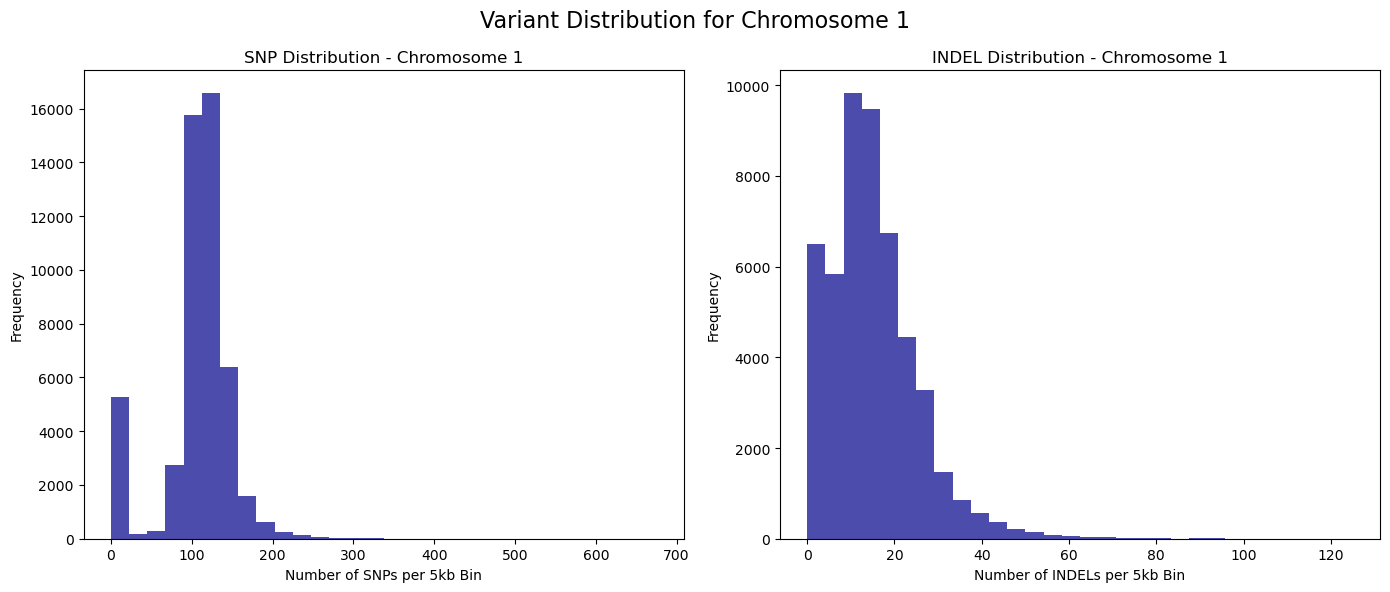


Processing chromosome 2...
Running: bcftools query -f '%POS\t%TYPE\n' ../data/hgdp1kgp_chr2.filtered.SNV_INDEL.phased.shapeit5.bcf > /var/folders/96/2s64979965l0x1hmvz6rctxh0000gp/T/tmps8cyb1kr/variants.txt
Running: bcftools stats ../data/hgdp1kgp_chr2.filtered.SNV_INDEL.phased.shapeit5.bcf | grep 'SN.*sequence.*length:' | head -1 | cut -f4
Could not get chromosome length from stats, using max position from variants
Running: bcftools query -f '%POS\n' ../data/hgdp1kgp_chr2.filtered.SNV_INDEL.phased.shapeit5.bcf | sort -n | tail -1


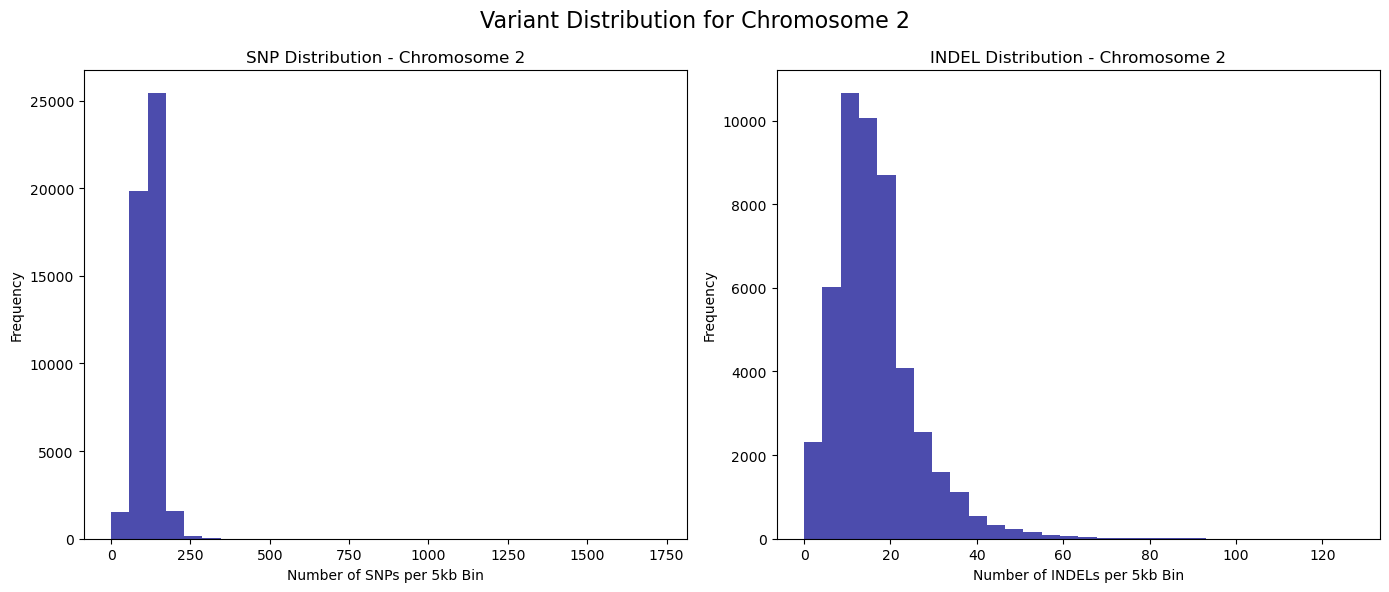


Processing chromosome 4...
Running: bcftools query -f '%POS\t%TYPE\n' ../data/hgdp1kgp_chr4.filtered.SNV_INDEL.phased.shapeit5.bcf > /var/folders/96/2s64979965l0x1hmvz6rctxh0000gp/T/tmps8cyb1kr/variants.txt
Running: bcftools stats ../data/hgdp1kgp_chr4.filtered.SNV_INDEL.phased.shapeit5.bcf | grep 'SN.*sequence.*length:' | head -1 | cut -f4
Could not get chromosome length from stats, using max position from variants
Running: bcftools query -f '%POS\n' ../data/hgdp1kgp_chr4.filtered.SNV_INDEL.phased.shapeit5.bcf | sort -n | tail -1


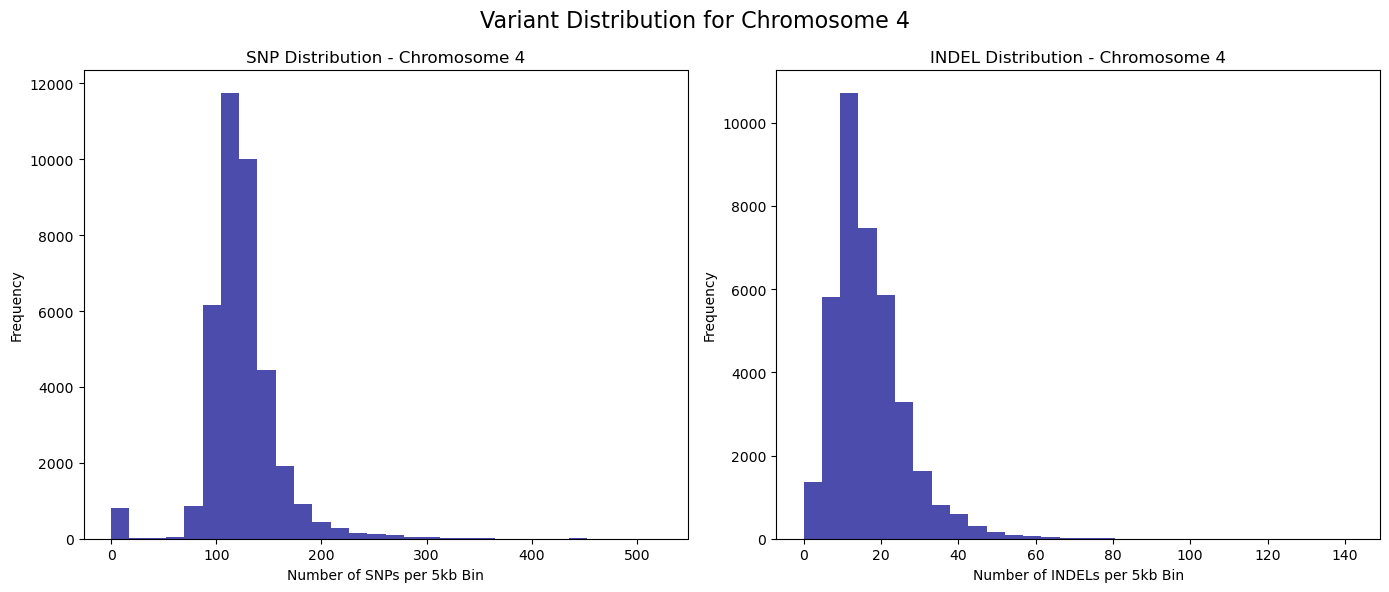


Processing chromosome 19...
Running: bcftools query -f '%POS\t%TYPE\n' ../data/hgdp1kgp_chr19.filtered.SNV_INDEL.phased.shapeit5.bcf > /var/folders/96/2s64979965l0x1hmvz6rctxh0000gp/T/tmps8cyb1kr/variants.txt
Running: bcftools stats ../data/hgdp1kgp_chr19.filtered.SNV_INDEL.phased.shapeit5.bcf | grep 'SN.*sequence.*length:' | head -1 | cut -f4
Could not get chromosome length from stats, using max position from variants
Running: bcftools query -f '%POS\n' ../data/hgdp1kgp_chr19.filtered.SNV_INDEL.phased.shapeit5.bcf | sort -n | tail -1


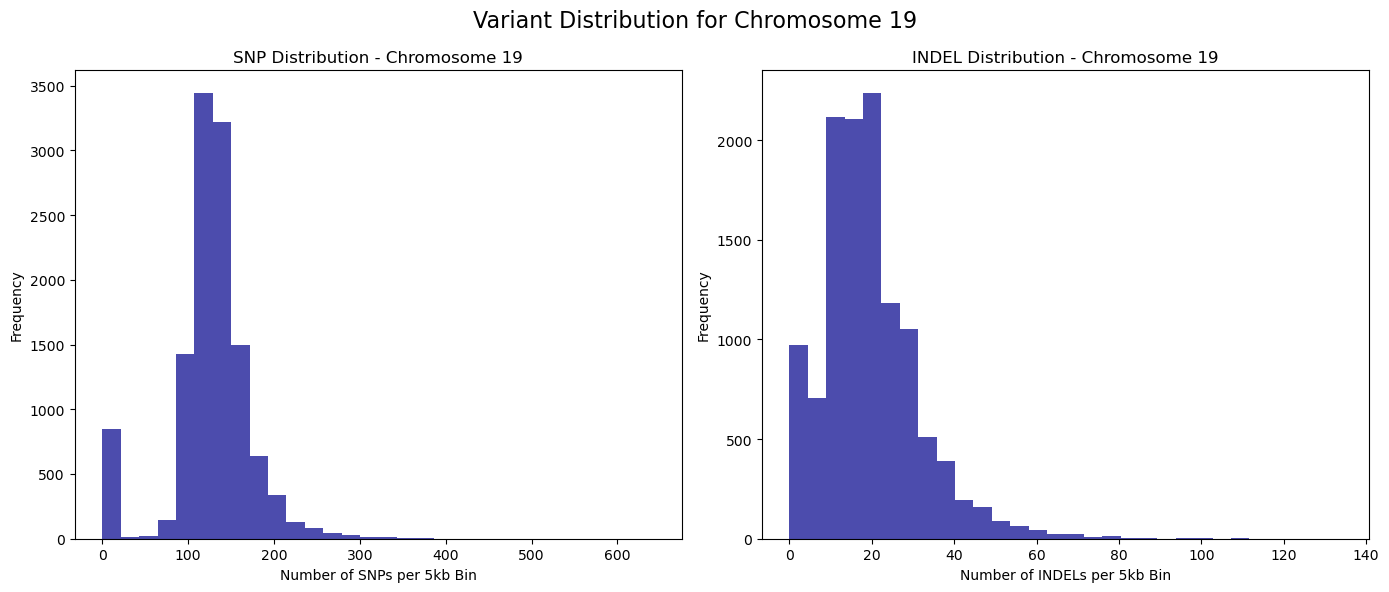


Processing chromosome 7...
Running: bcftools query -f '%POS\t%TYPE\n' ../data/hgdp1kgp_chr7.filtered.SNV_INDEL.phased.shapeit5.bcf > /var/folders/96/2s64979965l0x1hmvz6rctxh0000gp/T/tmps8cyb1kr/variants.txt
Running: bcftools stats ../data/hgdp1kgp_chr7.filtered.SNV_INDEL.phased.shapeit5.bcf | grep 'SN.*sequence.*length:' | head -1 | cut -f4
Could not get chromosome length from stats, using max position from variants
Running: bcftools query -f '%POS\n' ../data/hgdp1kgp_chr7.filtered.SNV_INDEL.phased.shapeit5.bcf | sort -n | tail -1


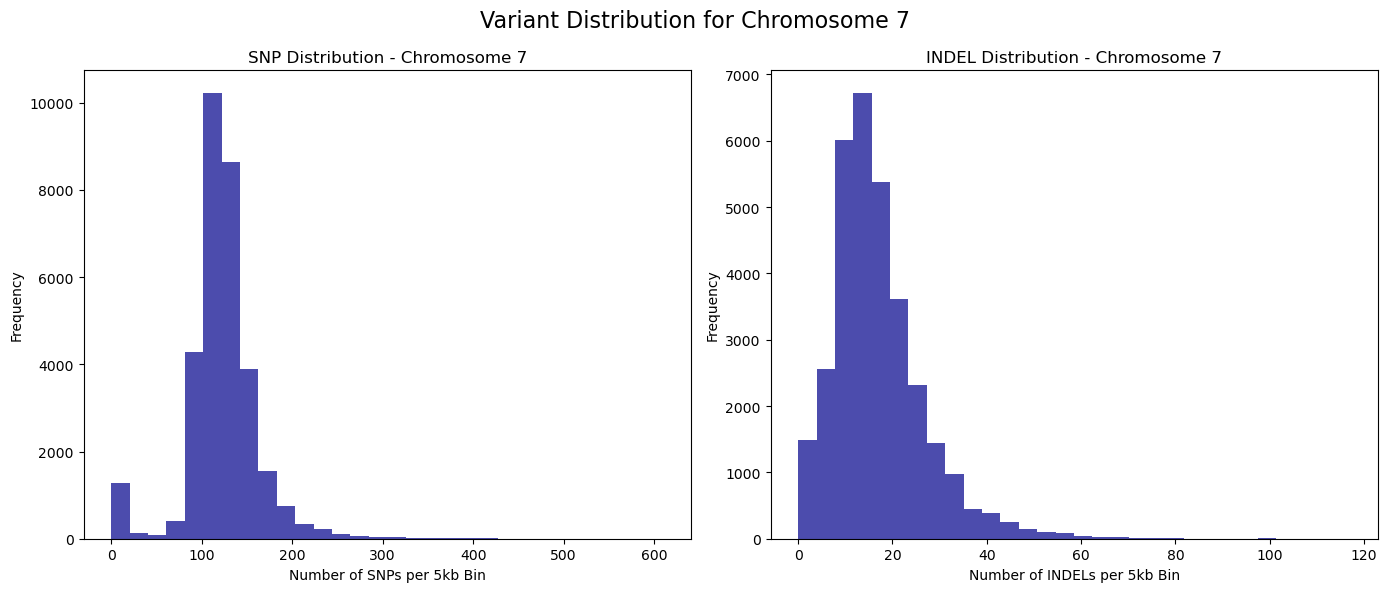


Processing chromosome 6...
Running: bcftools query -f '%POS\t%TYPE\n' ../data/hgdp1kgp_chr6.filtered.SNV_INDEL.phased.shapeit5.bcf > /var/folders/96/2s64979965l0x1hmvz6rctxh0000gp/T/tmps8cyb1kr/variants.txt
Running: bcftools stats ../data/hgdp1kgp_chr6.filtered.SNV_INDEL.phased.shapeit5.bcf | grep 'SN.*sequence.*length:' | head -1 | cut -f4
Could not get chromosome length from stats, using max position from variants
Running: bcftools query -f '%POS\n' ../data/hgdp1kgp_chr6.filtered.SNV_INDEL.phased.shapeit5.bcf | sort -n | tail -1


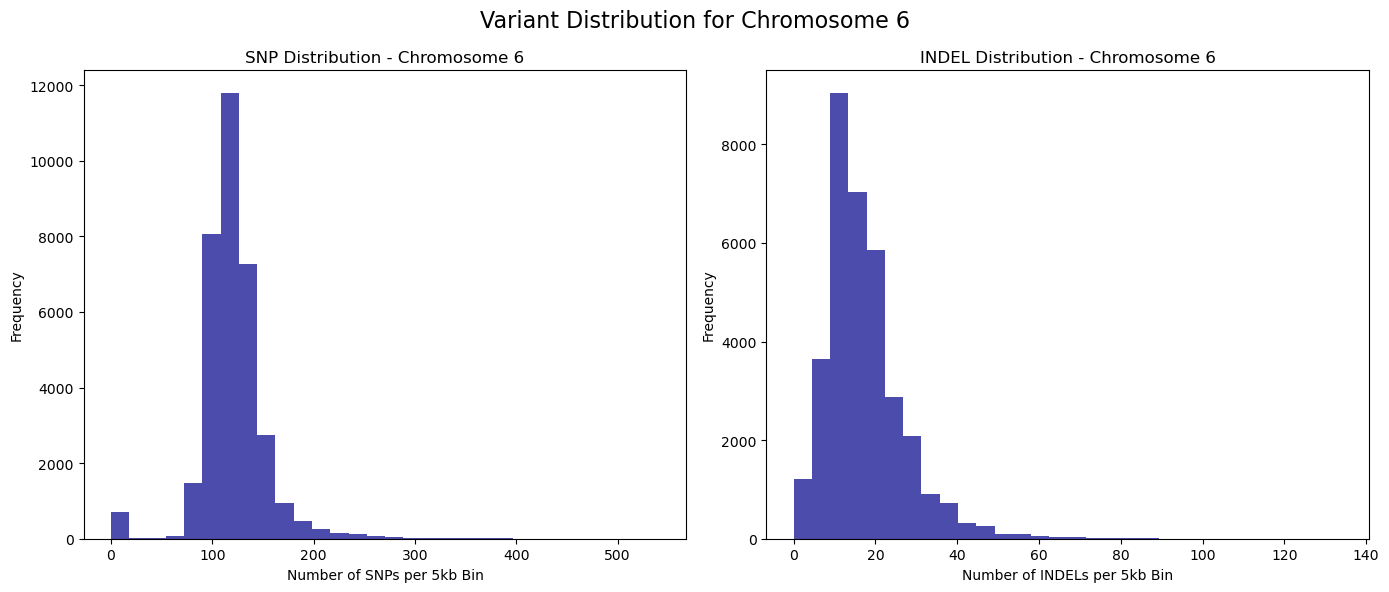


Processing chromosome 18...
Running: bcftools query -f '%POS\t%TYPE\n' ../data/hgdp1kgp_chr18.filtered.SNV_INDEL.phased.shapeit5.bcf > /var/folders/96/2s64979965l0x1hmvz6rctxh0000gp/T/tmps8cyb1kr/variants.txt
Running: bcftools stats ../data/hgdp1kgp_chr18.filtered.SNV_INDEL.phased.shapeit5.bcf | grep 'SN.*sequence.*length:' | head -1 | cut -f4
Could not get chromosome length from stats, using max position from variants
Running: bcftools query -f '%POS\n' ../data/hgdp1kgp_chr18.filtered.SNV_INDEL.phased.shapeit5.bcf | sort -n | tail -1


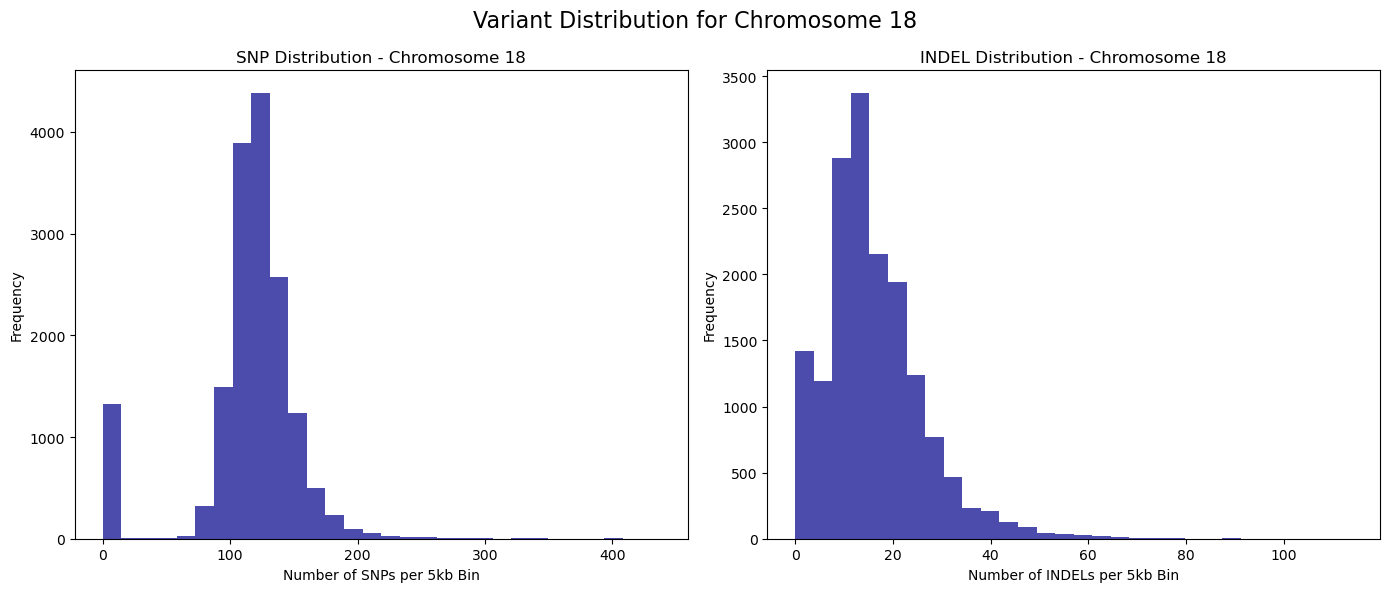


Processing chromosome 5...
Running: bcftools query -f '%POS\t%TYPE\n' ../data/hgdp1kgp_chr5.filtered.SNV_INDEL.phased.shapeit5.bcf > /var/folders/96/2s64979965l0x1hmvz6rctxh0000gp/T/tmps8cyb1kr/variants.txt
Running: bcftools stats ../data/hgdp1kgp_chr5.filtered.SNV_INDEL.phased.shapeit5.bcf | grep 'SN.*sequence.*length:' | head -1 | cut -f4
Could not get chromosome length from stats, using max position from variants
Running: bcftools query -f '%POS\n' ../data/hgdp1kgp_chr5.filtered.SNV_INDEL.phased.shapeit5.bcf | sort -n | tail -1


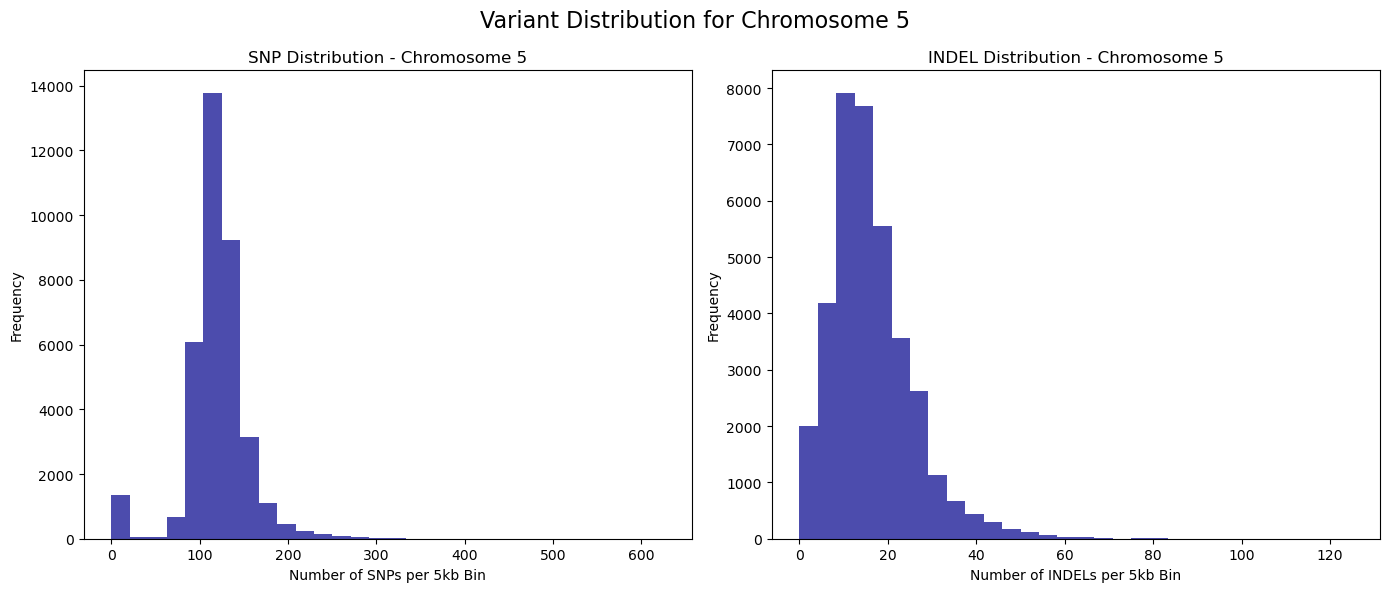


Processing chromosome 3...
Running: bcftools query -f '%POS\t%TYPE\n' ../data/hgdp1kgp_chr3.filtered.SNV_INDEL.phased.shapeit5.bcf > /var/folders/96/2s64979965l0x1hmvz6rctxh0000gp/T/tmps8cyb1kr/variants.txt
Running: bcftools stats ../data/hgdp1kgp_chr3.filtered.SNV_INDEL.phased.shapeit5.bcf | grep 'SN.*sequence.*length:' | head -1 | cut -f4
Could not get chromosome length from stats, using max position from variants
Running: bcftools query -f '%POS\n' ../data/hgdp1kgp_chr3.filtered.SNV_INDEL.phased.shapeit5.bcf | sort -n | tail -1


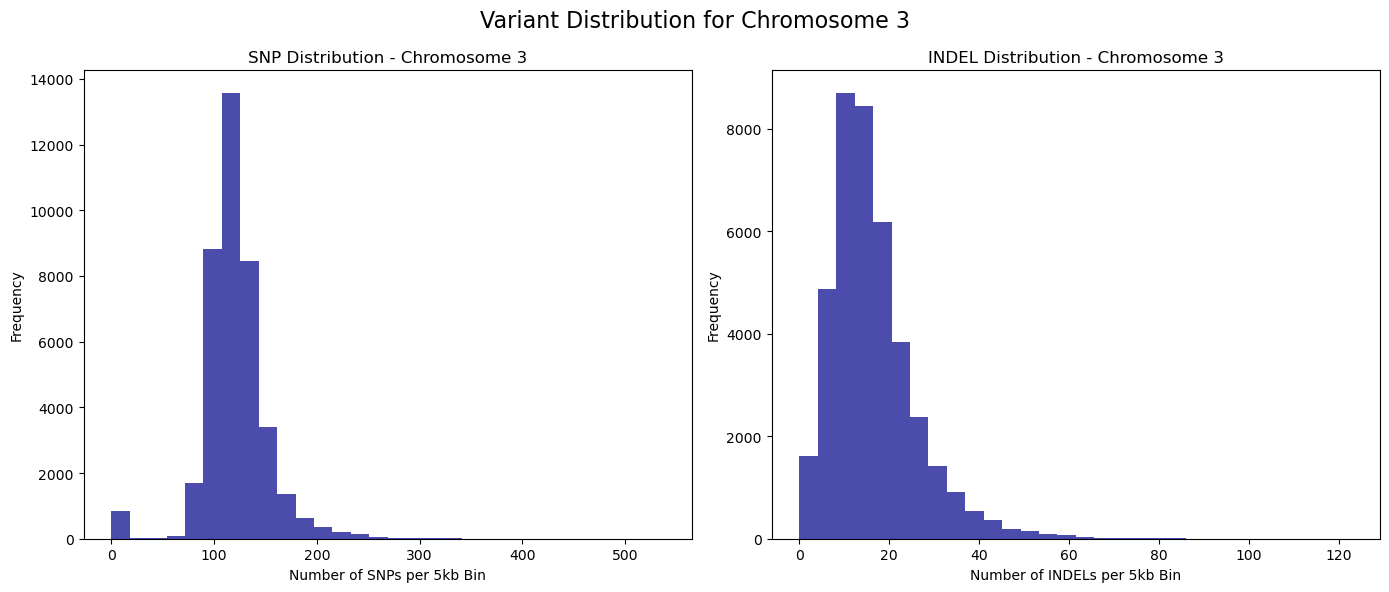


Processing chromosome 12...
Running: bcftools query -f '%POS\t%TYPE\n' ../data/hgdp1kgp_chr12.filtered.SNV_INDEL.phased.shapeit5.bcf > /var/folders/96/2s64979965l0x1hmvz6rctxh0000gp/T/tmps8cyb1kr/variants.txt
Running: bcftools stats ../data/hgdp1kgp_chr12.filtered.SNV_INDEL.phased.shapeit5.bcf | grep 'SN.*sequence.*length:' | head -1 | cut -f4
Could not get chromosome length from stats, using max position from variants
Running: bcftools query -f '%POS\n' ../data/hgdp1kgp_chr12.filtered.SNV_INDEL.phased.shapeit5.bcf | sort -n | tail -1


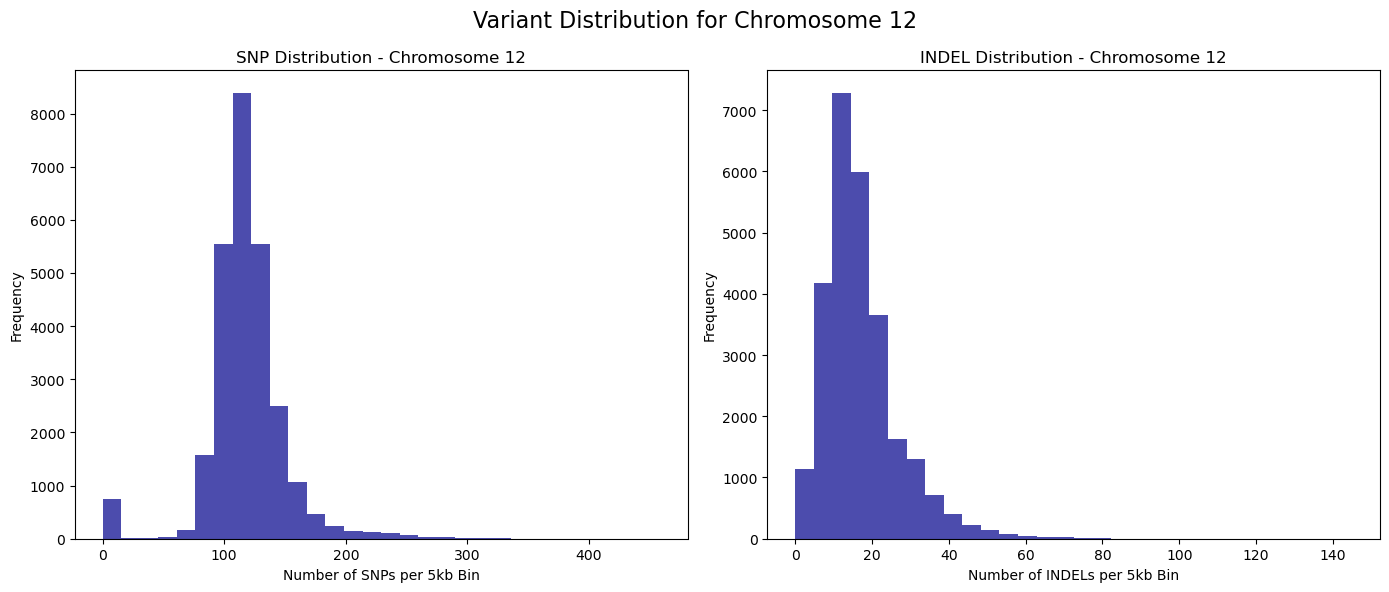


Processing chromosome 11...
Running: bcftools query -f '%POS\t%TYPE\n' ../data/hgdp1kgp_chr11.filtered.SNV_INDEL.phased.shapeit5.bcf > /var/folders/96/2s64979965l0x1hmvz6rctxh0000gp/T/tmps8cyb1kr/variants.txt
Running: bcftools stats ../data/hgdp1kgp_chr11.filtered.SNV_INDEL.phased.shapeit5.bcf | grep 'SN.*sequence.*length:' | head -1 | cut -f4
Could not get chromosome length from stats, using max position from variants
Running: bcftools query -f '%POS\n' ../data/hgdp1kgp_chr11.filtered.SNV_INDEL.phased.shapeit5.bcf | sort -n | tail -1


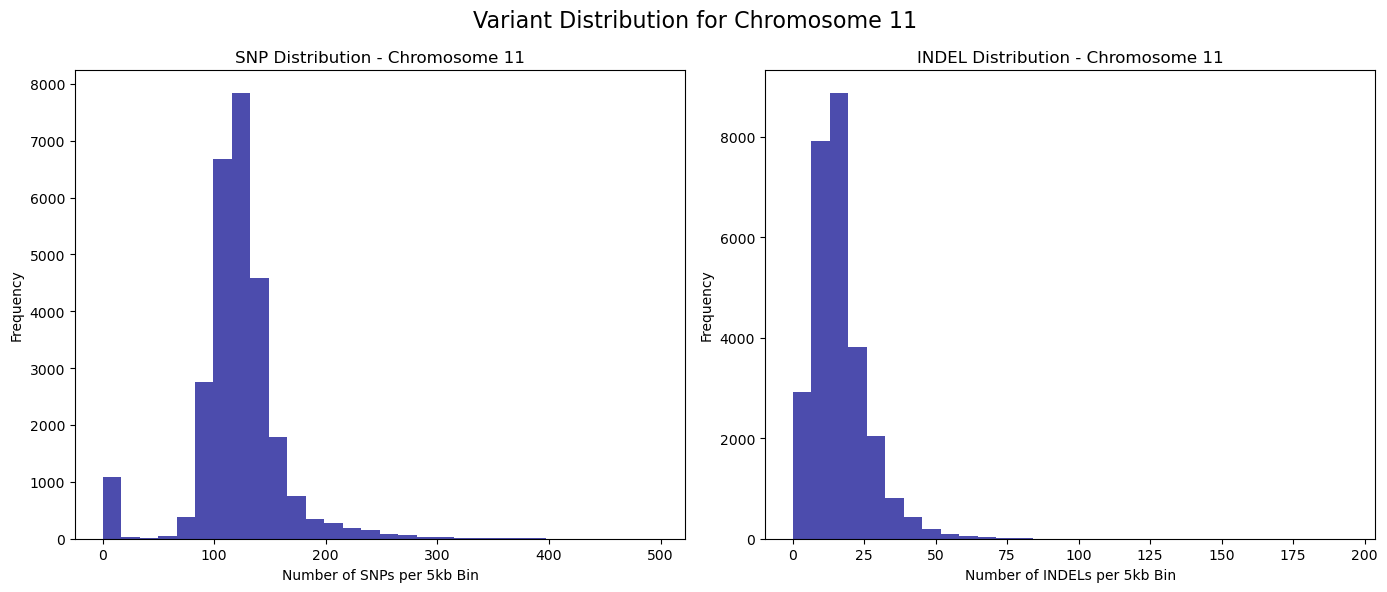


Processing chromosome 22...
Running: bcftools query -f '%POS\t%TYPE\n' ../data/hgdp1kgp_chr22.filtered.SNV_INDEL.phased.shapeit5.bcf > /var/folders/96/2s64979965l0x1hmvz6rctxh0000gp/T/tmps8cyb1kr/variants.txt
Running: bcftools stats ../data/hgdp1kgp_chr22.filtered.SNV_INDEL.phased.shapeit5.bcf | grep 'SN.*sequence.*length:' | head -1 | cut -f4
Could not get chromosome length from stats, using max position from variants
Running: bcftools query -f '%POS\n' ../data/hgdp1kgp_chr22.filtered.SNV_INDEL.phased.shapeit5.bcf | sort -n | tail -1


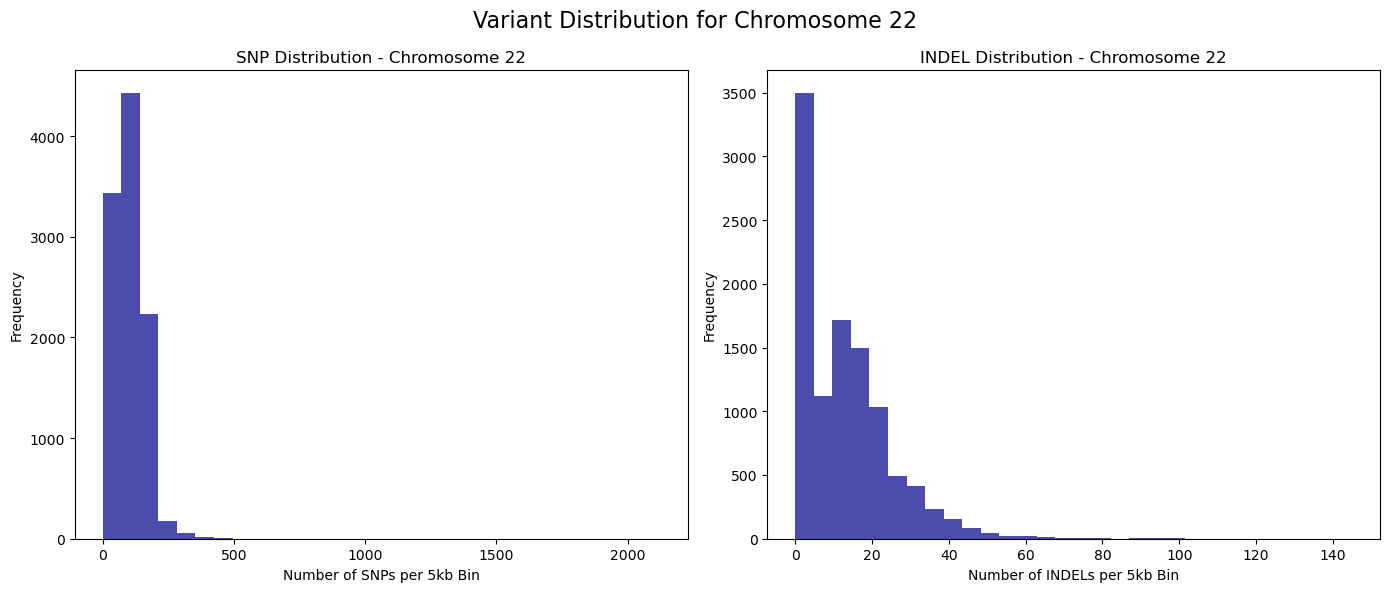


Processing chromosome 17...
Running: bcftools query -f '%POS\t%TYPE\n' ../data/hgdp1kgp_chr17.filtered.SNV_INDEL.phased.shapeit5.bcf > /var/folders/96/2s64979965l0x1hmvz6rctxh0000gp/T/tmps8cyb1kr/variants.txt
Running: bcftools stats ../data/hgdp1kgp_chr17.filtered.SNV_INDEL.phased.shapeit5.bcf | grep 'SN.*sequence.*length:' | head -1 | cut -f4
Could not get chromosome length from stats, using max position from variants
Running: bcftools query -f '%POS\n' ../data/hgdp1kgp_chr17.filtered.SNV_INDEL.phased.shapeit5.bcf | sort -n | tail -1


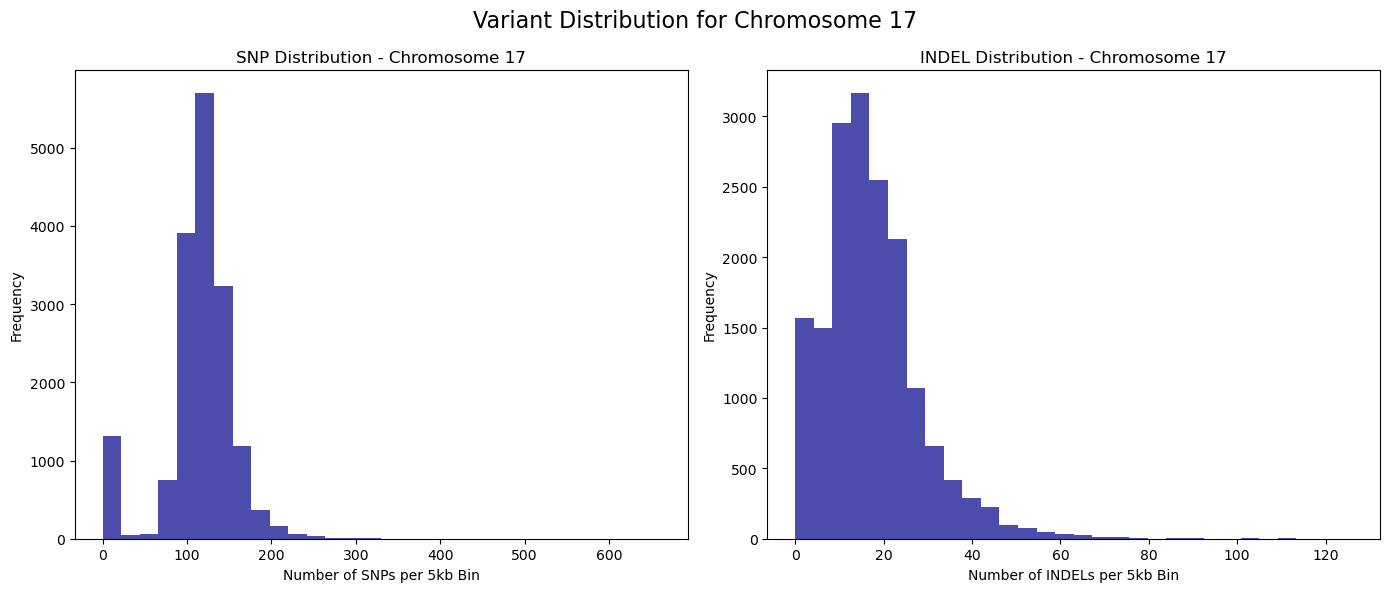


Processing chromosome 14...
Running: bcftools query -f '%POS\t%TYPE\n' ../data/hgdp1kgp_chr14.filtered.SNV_INDEL.phased.shapeit5.bcf > /var/folders/96/2s64979965l0x1hmvz6rctxh0000gp/T/tmps8cyb1kr/variants.txt
Running: bcftools stats ../data/hgdp1kgp_chr14.filtered.SNV_INDEL.phased.shapeit5.bcf | grep 'SN.*sequence.*length:' | head -1 | cut -f4
Could not get chromosome length from stats, using max position from variants
Running: bcftools query -f '%POS\n' ../data/hgdp1kgp_chr14.filtered.SNV_INDEL.phased.shapeit5.bcf | sort -n | tail -1


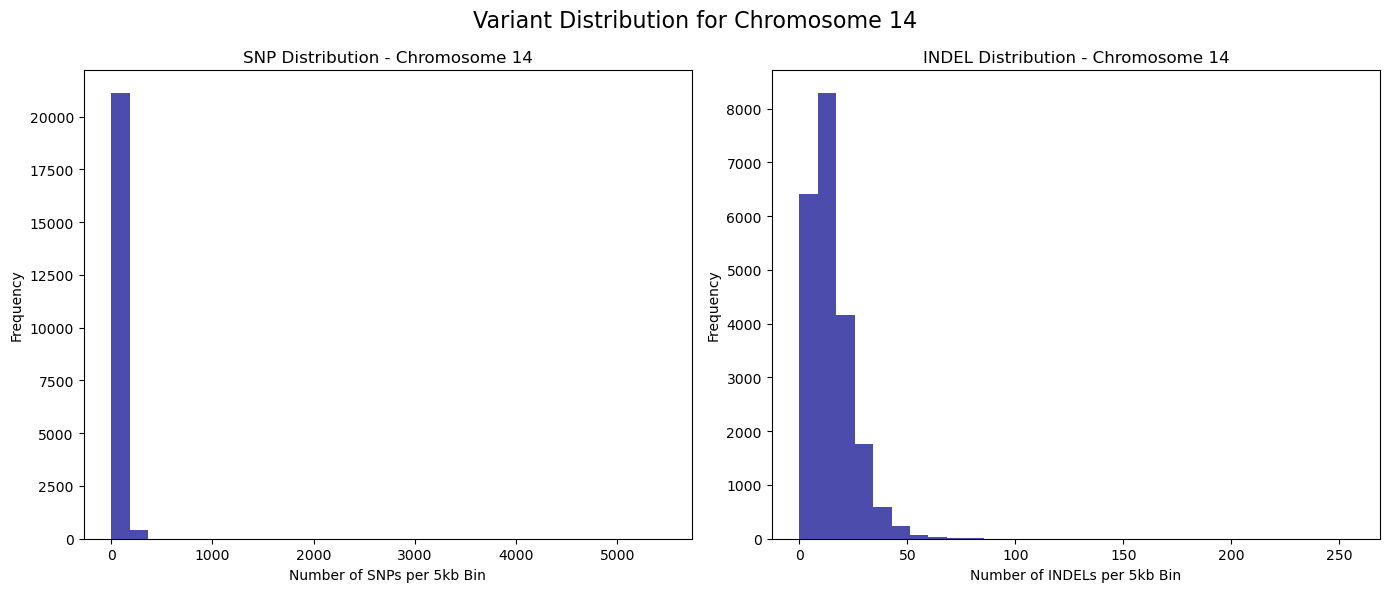


Processing chromosome 9...
Running: bcftools query -f '%POS\t%TYPE\n' ../data/hgdp1kgp_chr9.filtered.SNV_INDEL.phased.shapeit5.bcf > /var/folders/96/2s64979965l0x1hmvz6rctxh0000gp/T/tmps8cyb1kr/variants.txt
Running: bcftools stats ../data/hgdp1kgp_chr9.filtered.SNV_INDEL.phased.shapeit5.bcf | grep 'SN.*sequence.*length:' | head -1 | cut -f4
Could not get chromosome length from stats, using max position from variants
Running: bcftools query -f '%POS\n' ../data/hgdp1kgp_chr9.filtered.SNV_INDEL.phased.shapeit5.bcf | sort -n | tail -1


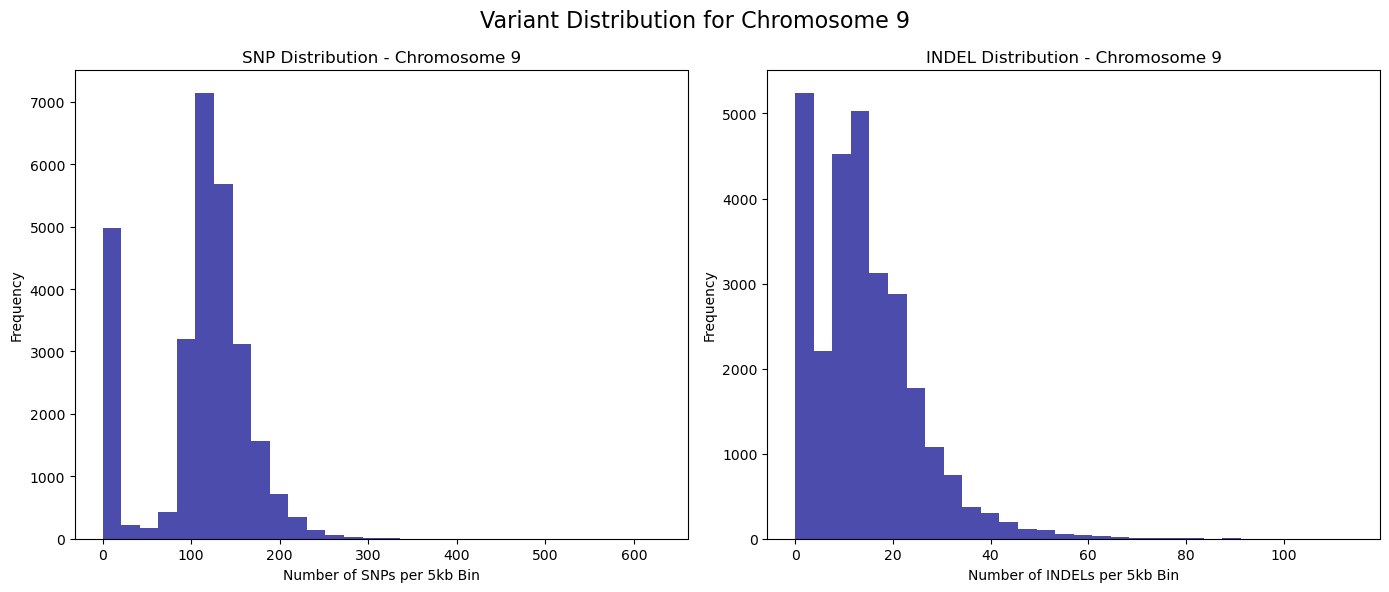


Processing chromosome 21...
Running: bcftools query -f '%POS\t%TYPE\n' ../data/hgdp1kgp_chr21.filtered.SNV_INDEL.phased.shapeit5.bcf > /var/folders/96/2s64979965l0x1hmvz6rctxh0000gp/T/tmps8cyb1kr/variants.txt
Running: bcftools stats ../data/hgdp1kgp_chr21.filtered.SNV_INDEL.phased.shapeit5.bcf | grep 'SN.*sequence.*length:' | head -1 | cut -f4
Could not get chromosome length from stats, using max position from variants
Running: bcftools query -f '%POS\n' ../data/hgdp1kgp_chr21.filtered.SNV_INDEL.phased.shapeit5.bcf | sort -n | tail -1


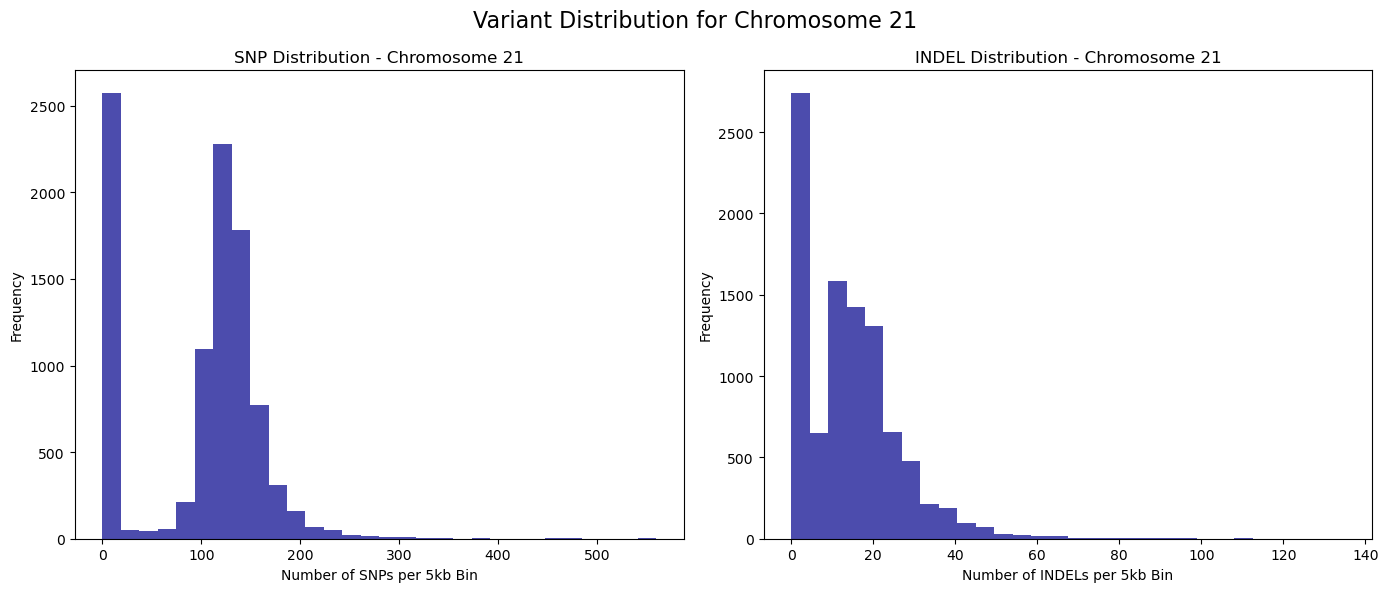

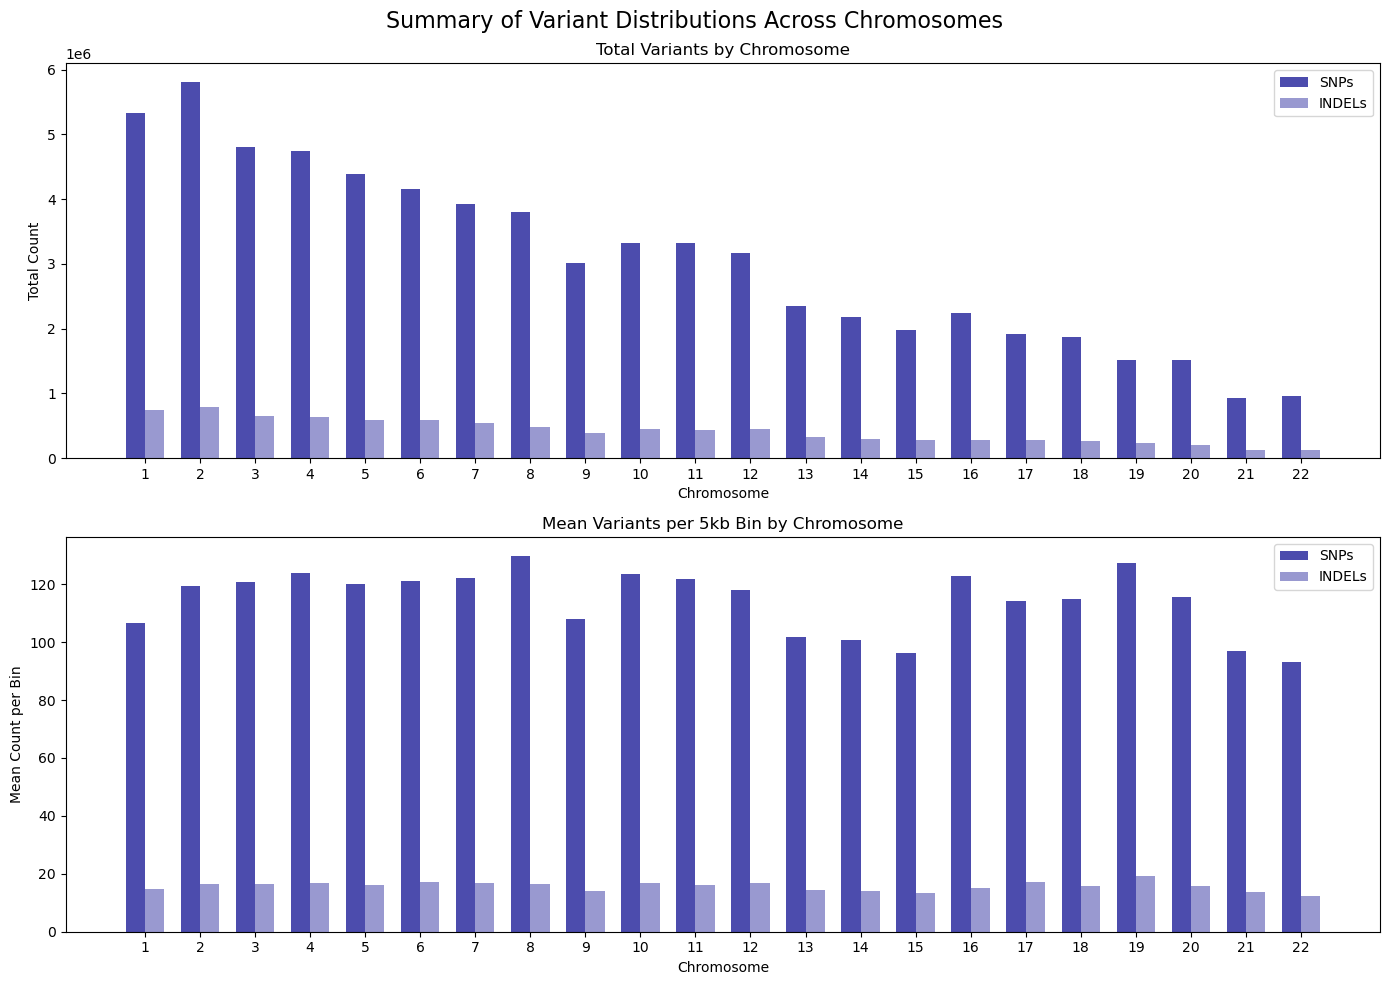

In [39]:
bcf_files = get_local_bcf_files()

# Create output directory for figures
import os
if not os.path.exists("./distribution_figures"):
    os.makedirs("./distribution_figures")

# Create distribution figures
# You can limit the number of chromosomes if needed
# For example, to analyze only first 3 chromosomes: bcf_files[:3]
create_chromosome_distribution_figures(bcf_files, output_dir="./distribution_figures")
